# Metody Obliczeniowe w Nauce i Technice Laboratorium 4
## Symulowane wyżarzanie
### Paweł Gorgolewski

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import namedtuple, Counter
from typing import List, Tuple
from abc import ABC, abstractmethod
import math
import itertools
import copy
import functools

## 1. TSP

##### Struktury użyte w rozwiązaniu:
1) Point - namedtuple zawierająca współrzędne oraz id miasta
2) Temperature - klasa wykorzystywana do obsługi funkcji temperatury
3) Annealing - abstrakcyjna klasa po której dziedziczy TSP
4) TSP - klasa wykorzystywana do obliczenia najkrótszej trasy

In [3]:
Point = namedtuple("Point", ["x", "y", "id"])

class Temperature:
    def __init__(self, max_iterations: int):
        self._delta = None
        self._min_temp = self._temp = self._max_temp = None
        self._max_iterations = max_iterations
        self._probability = 1
        self._probabilities_over_time = [self._probability]
        self.strategy = None

    def set_exponential(self, min_temp = -8):
        self.strategy = self._exponential
        self._min_temp = min_temp
        self._max_temp = 0
        self._temp = self._max_temp
        self._delta = abs(self._min_temp) / self._max_iterations

    def set_linear(self):
        self.strategy = self._linear
        self._min_temp = 0
        self._max_temp = self._max_iterations
        self._temp = self._max_temp
        self._delta = 1

    @property
    def probability(self):
        return self._probability

    def draw(self, ax=None):
        p = ax if ax else plt
        p.plot(list(range(len(self._probabilities_over_time))), self._probabilities_over_time)
        p.set_title("Probability of taking worse solution over iterations")

        if not ax:
            p.xlabel("Iterations")
            p.ylabel("Probability")
            p.show()
        else:
            p.set(xlabel="Iterations", ylabel="Probability")

    def _linear(self):
        self._temp -= self._delta
        self._probability = self._temp / self._max_temp

    def _exponential(self):
        self._temp -= self._delta
        self._probability = math.exp(self._temp)

    def cool_down(self):
        self.strategy()
        self._probabilities_over_time.append(self._probability)

class Annealing(ABC):
    def __init__(self, max_iterations: int):
        self._results_over_time = list()
        self._temp = Temperature(max_iterations)
        self._max_iterations = max_iterations
        self._is_used = False
        self._consecutive_swap = False #by default arbitrary swap
        super().__init__()

    def _reset(self, max_iterations: int):
        self._results_over_time = list()
        self._temp = Temperature(max_iterations)
        self._max_iterations = max_iterations
        self._is_used = False
        self._consecutive_swap = False #by default arbitrary swap

    def set_consecutive_swap(self):
        self._consecutive_swap = True

    def set_exponential(self, min_temp):
        self._temp.set_exponential(min_temp)

    def set_linear(self):
        self._temp.set_linear()

    def draw_annealing_and_probability(self, xlabel="Iterations", ylabel="Distance"):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9), dpi=80)
        self.draw_annealing(ax1, xlabel, ylabel)
        self.draw_probability(ax2)
        fig.tight_layout()

    def draw_annealing(self, ax=None, xlabel="Iterations", ylabel="Distance"):
        p = ax if ax else plt
        p.plot(list(range(self._max_iterations+1)), self._results_over_time)
        p.set_title("Distance over iterations")
        if not ax:
            p.xlabel(xlabel)
            p.ylabel(ylabel)
            p.show()
        else:
            p.set(xlabel=xlabel, ylabel=ylabel)

    def draw_probability(self, ax=None):
        self._temp.draw(ax)

    @abstractmethod
    def draw(self, node_size=None):
        pass

    @abstractmethod
    def solve(self):
        pass

class TSP(Annealing):
    def __init__(self, cities: List[Point], max_iterations: int):
        super().__init__(max_iterations)
        self._cities = cities.copy()
        self._n = len(cities)
        self._cities_distance = self._calculate_distances()
        self._best_cities_order = self._cities.copy()
        self._starting_order = copy.deepcopy(cities)
        self._best_distance = sum(self._cities_distance[self._cities[i].id, self._cities[(i+1) % self._n].id] for i in range(self._n))
        self._starting_distance = self._best_distance

    def set(self, cities: List[Point], max_iterations: int):
        self._reset(max_iterations)
        self._cities = cities.copy()
        self._n = len(cities)
        self._cities_distance = self._calculate_distances()
        self._best_cities_order = self._cities.copy()
        self._starting_order = copy.deepcopy(cities)
        self._best_distance = sum(self._cities_distance[self._cities[i].id, self._cities[(i+1) % self._n].id] for i in range(self._n))
        self._starting_distance = self._best_distance

    def solve(self):
        if self._is_used:
            raise Exception("Use .set() for TSP object to use it again")

        curr_distance = self._best_distance
        self._results_over_time.append(curr_distance)
        for step in range(1, self._max_iterations+1):
            index1, index2 = np.random.choice(range(self._n), 2, replace=False)

            if self._consecutive_swap:
                index2 = (index1 + 1) % self._n

            distance_difference = self._calculate_difference(index1, index2)

            random = np.random.random()
            if distance_difference > 0 or random < self._temp.probability:
                self._cities[index1], self._cities[index2] = self._cities[index2], self._cities[index1]
                curr_distance -= distance_difference

            if curr_distance < self._best_distance:
                self._best_distance = curr_distance
                self._best_cities_order = self._cities.copy()

            self._temp.cool_down()
            self._results_over_time.append(curr_distance)

        self._is_used = True
        self._cities = self._best_cities_order

    def _calculate_difference(self, i1: int, i2: int):
        p1_prev, p1, p1_next = self._cities[(i1-1) % self._n], self._cities[i1], self._cities[(i1+1) % self._n]
        p2_prev, p2, p2_next = self._cities[(i2-1) % self._n], self._cities[i2], self._cities[(i2+1) % self._n]

        before_change = self._cities_distance[p1.id, p1_next.id] + self._cities_distance[p1.id, p1_prev.id] +\
                        self._cities_distance[p2.id, p2_next.id] + self._cities_distance[p2.id, p2_prev.id]

        after_change = self._cities_distance[p1.id, p2_next.id] + self._cities_distance[p1.id, p2_prev.id] +\
                       self._cities_distance[p2.id, p1_next.id] + self._cities_distance[p2.id, p1_prev.id]

        # When chosen Points are connected, half of distances for `after_change` are equal to 0
        # if i1 + 1 == i2 then p1 == p2_prev and p2 == p1_next.
        # if i1 - 1 == i2 then p1 == p2_next and p2 == p1_prev.
        if abs(i1-i2) == 1 or (i1,i2) == (0, self._n-1) or (i1,i2) == (self._n-1, 0):
            after_change += 2* self._cities_distance[p2.id, p1.id]

        return before_change - after_change

    def _calculate_distances(self):
        distances = np.zeros((self._n, self._n))
        for i in range(self._n):
            for j in range(i+1, self._n):
                i_id, j_id = self._cities[i].id, self._cities[j].id
                distances[i_id, j_id] = distances[j_id, i_id] = self.point_distance(self._cities[i], self._cities[j])

        return distances

    def draw_starting_and_ending_graph(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9), dpi=80)
        self.draw(ax = ax1, starting_cities=True)
        self.draw(ax = ax2)
        fig.tight_layout()
        plt.show()

    def draw(self, node_size=250, ax=None, starting_cities=False):
        if ax:
            p = ax
        else:
            plt.figure(figsize=(20, 15), dpi=80)
            p = plt

        cities = self._starting_order if starting_cities else self._cities
        title = "STARTING DISTANCE" if starting_cities else "TOTAL DISTANCE"
        distance = self._starting_distance if starting_cities else self._best_distance

        G = nx.DiGraph()
        pos = dict()
        for i in range(self._n):
            G.add_node(i)
            pos[cities[i].id] = (cities[i].x, cities[i].y)

        for i in range(self._n):
            G.add_edge(cities[i].id, cities[(i+1) % self._n].id)

        nx.draw_networkx_nodes(G, pos, node_color = 'tab:red', node_size=node_size, ax=ax)
        nx.draw_networkx_edges(G, pos, ax=ax)
        p.set_title(f"{title}: {distance}")

        if not ax: plt.show()


    @staticmethod
    def point_distance(p1: Point, p2: Point):
        return math.sqrt((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2)

Najważniejszą częścią w powyższym kodzie jest metoda `solve()` w klasie TSP. To właśnie w niej wykonuje się cały algorytm wyrzażania.

##### Funkcje do generowania listy punktów

In [4]:
def generate_randoms(n):
    return [Point(np.random.random(), np.random.random(), i) for i in range(n)]

def generate_groups(n, groups):
    if n / groups % 1 != 0:
        raise Exception("N must be divided by groups ex. n=100 groups=5")

    sqrt_group = math.sqrt(groups)
    if not np.isclose(sqrt_group % 1, 0):
        raise Exception("Groups must have a square")

    xs = ys = round(sqrt_group)
    n_per_group = n // groups
    result, k, mul = list(), 0, 3
    for x,y in itertools.product(range(xs), range(ys)):
        result.extend([Point(np.random.random() + mul * x, np.random.random() + mul * y, index) for index in range(k, k + n_per_group)])
        k += n_per_group

    np.random.shuffle(result) #just to have totally random starting path
    return result

def generate_normal(n: int):
    mean = np.random.random(n)
    cov = np.eye(n)
    normal = np.random.multivariate_normal(mean, cov, 2)

    return [Point(normal[0][i], normal[1][i], i) for i in range(n)]

##### Funkcja wykonywania algorytmu

In [5]:
def run_tsp(repeat, generation_args, tsp_args, linear=False, generation=generate_randoms, seed=None, consecutive_swap=False, min_temp=-8):
    if seed: np.random.seed(seed)
    cities = generation(**generation_args)
    tsp = TSP(cities, **tsp_args)

    if linear: tsp.set_linear()
    else: tsp.set_exponential(min_temp)
    if consecutive_swap: tsp.set_consecutive_swap()

    for i in range(1, repeat+1):
        tsp.solve()
        print(f"SOLUTION IN INTERATION NUMBER: {i}")
        tsp.draw_starting_and_ending_graph()
        tsp.draw_annealing_and_probability()
        tsp.set(cities, **tsp_args)
        if linear: tsp.set_linear()
        else: tsp.set_exponential(min_temp)
        if consecutive_swap: tsp.set_consecutive_swap()

### 1.1 Wizualizacja rozwiązania przy różnych rozkładach punktów

Kolejne wizualizacje stworzone zostały przy tylko jednej próbie algorytmu. W celu znalezienia 'większego' optimum, należy powtórzyć algorytm pewną liczbę razy (np. 5) bez ustawionego *seed'a*. Dzieje się tak, gdyż jest to algorytm stochastyczny - może utknąć w minimum lokalnym i nie dojść do globalnego.

W tym punkcie wszystkie rozwiązania używają `arbitrary swap` (czyli miejscami zamieniają się dwa losowe punkty) oraz eksponencjalnej funkcji zmiany temperatury


#### Rozkład jednostajny
Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 20 punktów
4. $e^{-x}$ jako funkcja prawdopodobieństwa

SOLUTION IN INTERATION NUMBER: 1


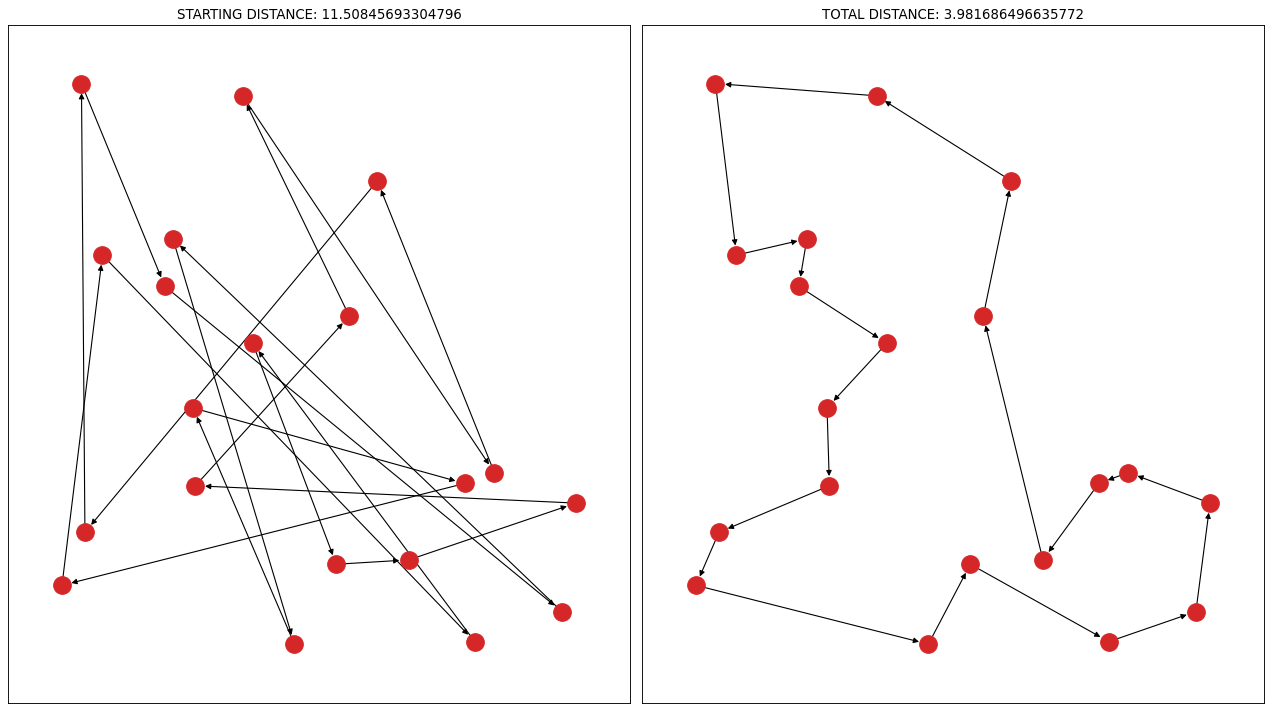

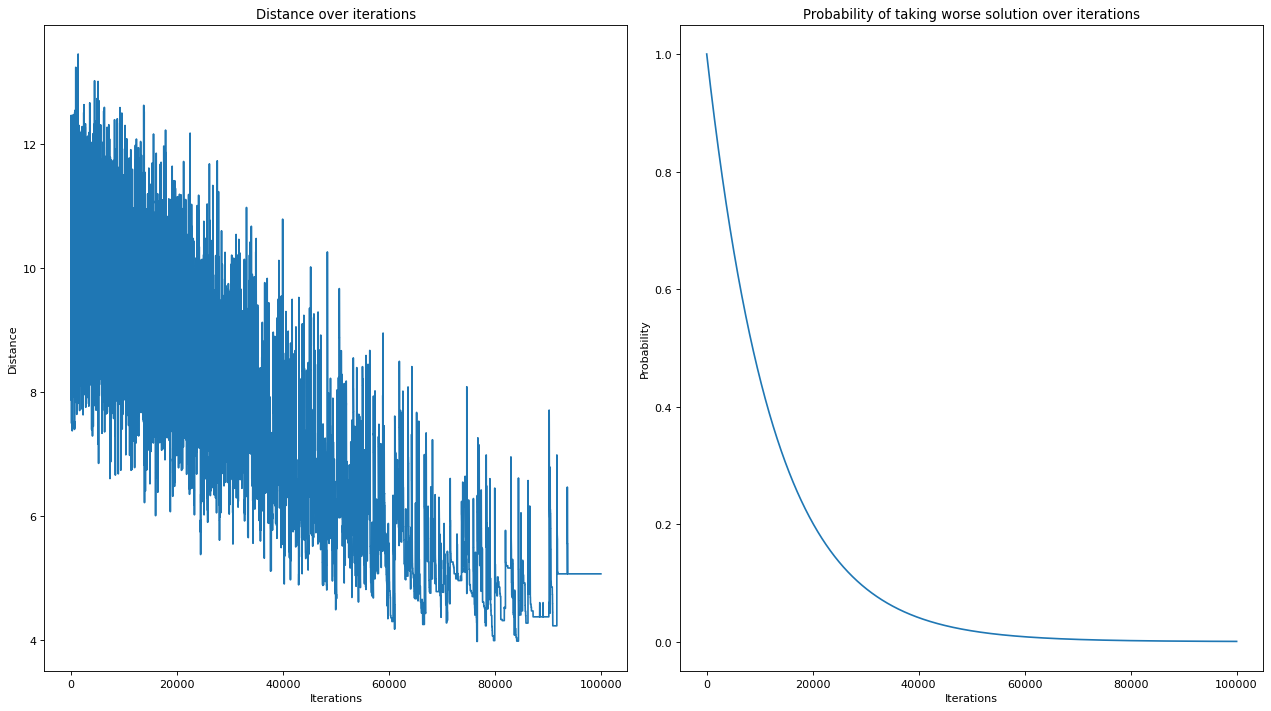

In [6]:
run_tsp(1, {'n': 20}, {'max_iterations': 10**5})

Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 40 punktów
4. $e^{-x}$ jako funkcja prawdopodobieństwa

SOLUTION IN INTERATION NUMBER: 1


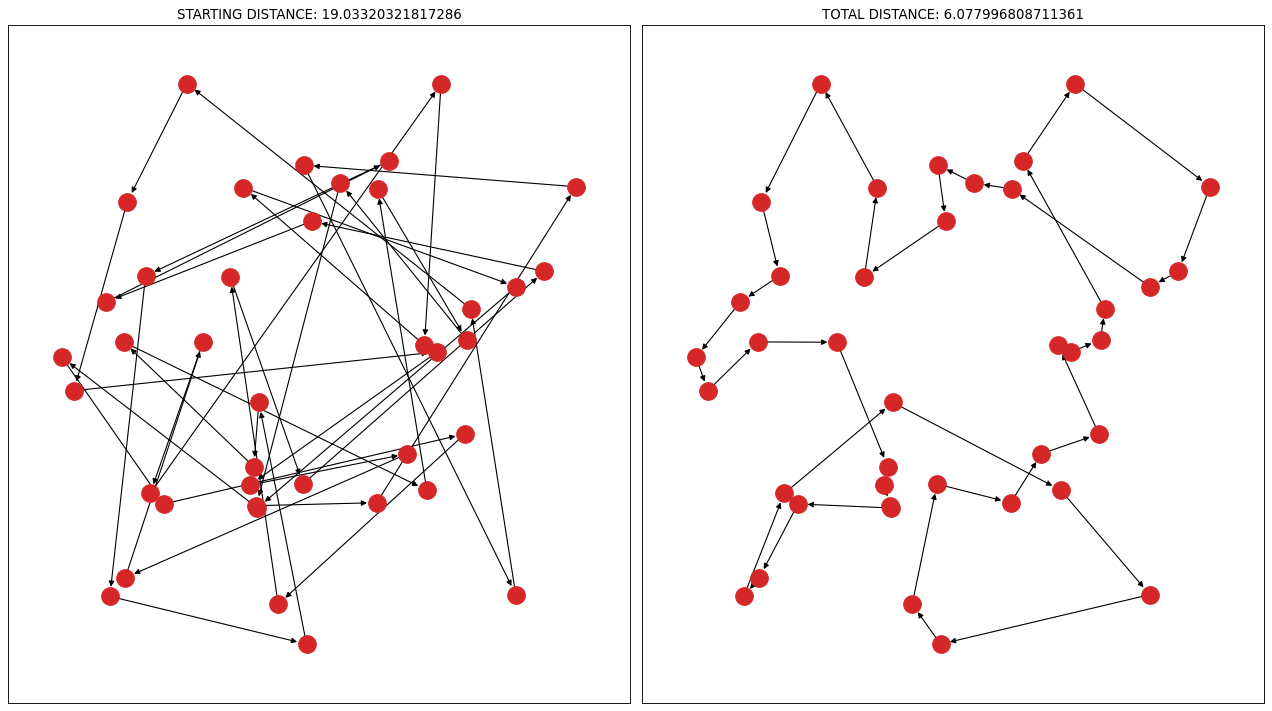

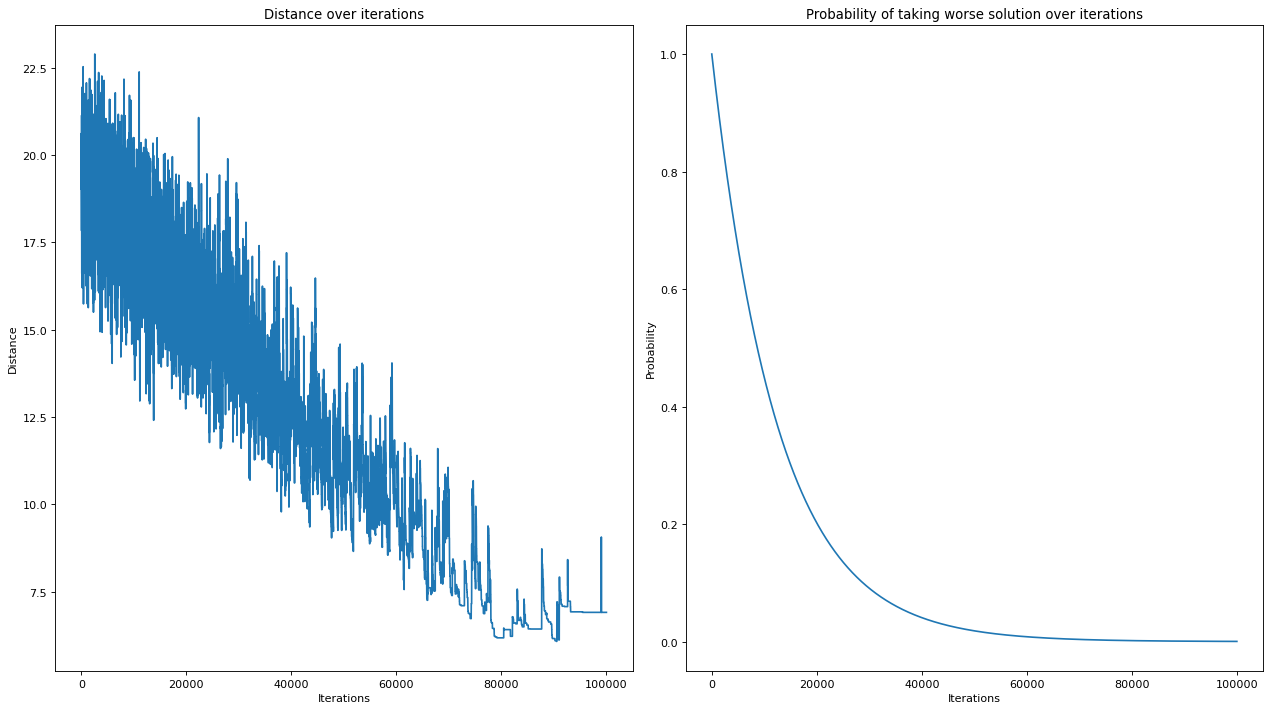

In [7]:
run_tsp(1, {'n': 40}, {'max_iterations': 10**5})

Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 80 punktów
4. $e^{-x}$ jako funkcja prawdopodobieństwa

SOLUTION IN INTERATION NUMBER: 1


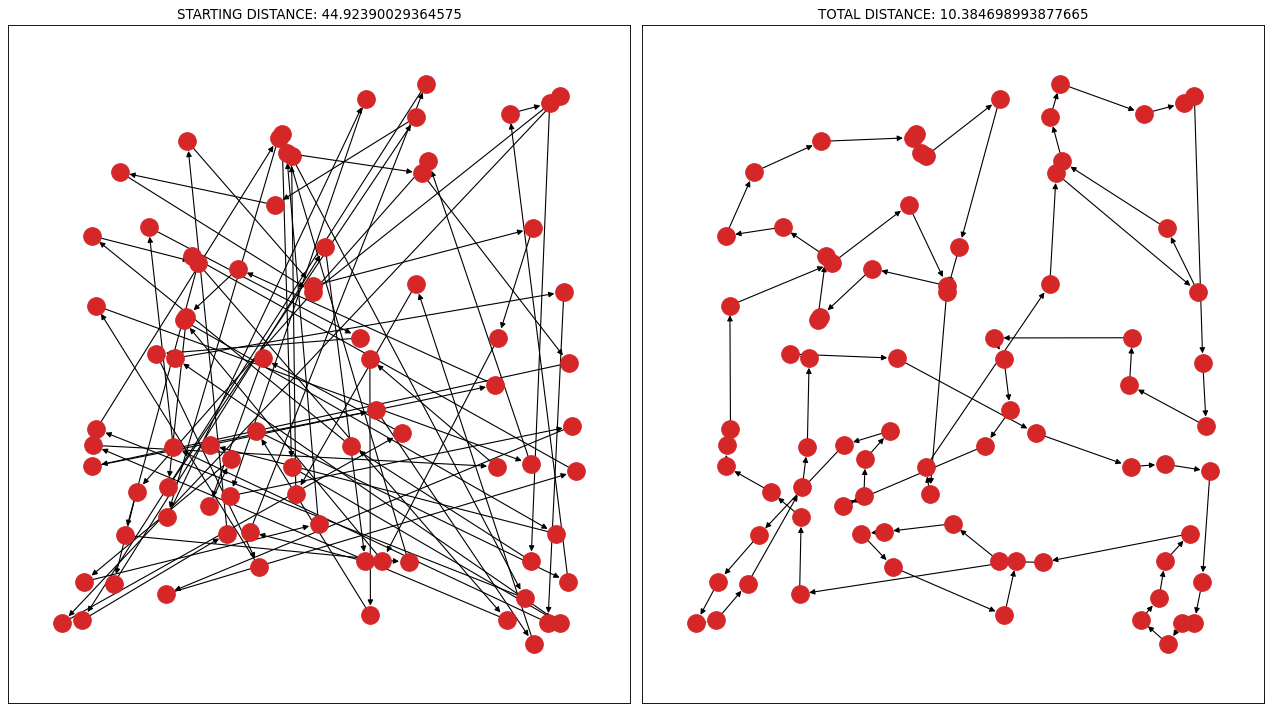

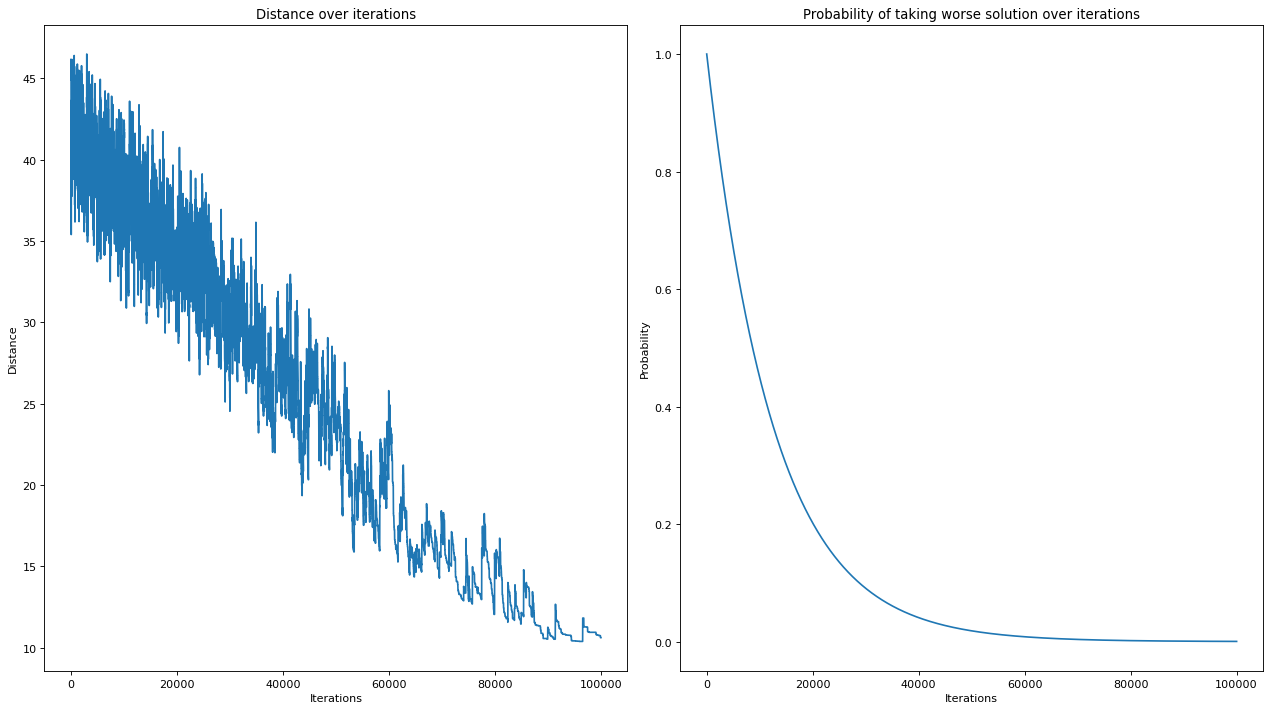

In [8]:
run_tsp(1, {'n': 80}, {'max_iterations': 10**5})

#### Dziewięć odseparowanych grup punktów
Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 27 punktów -> 9 grup po 3 punkty
4. $e^{-x}$ jako funkcja prawdopodobieństwa

SOLUTION IN INTERATION NUMBER: 1


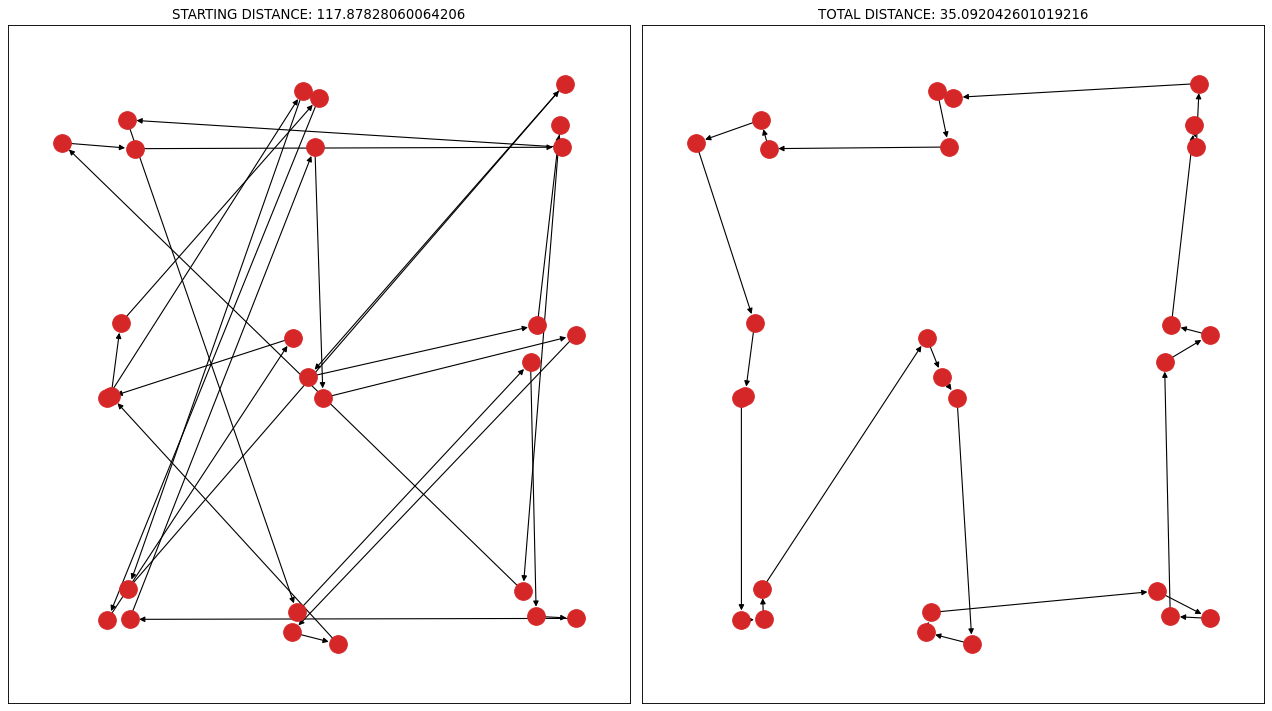

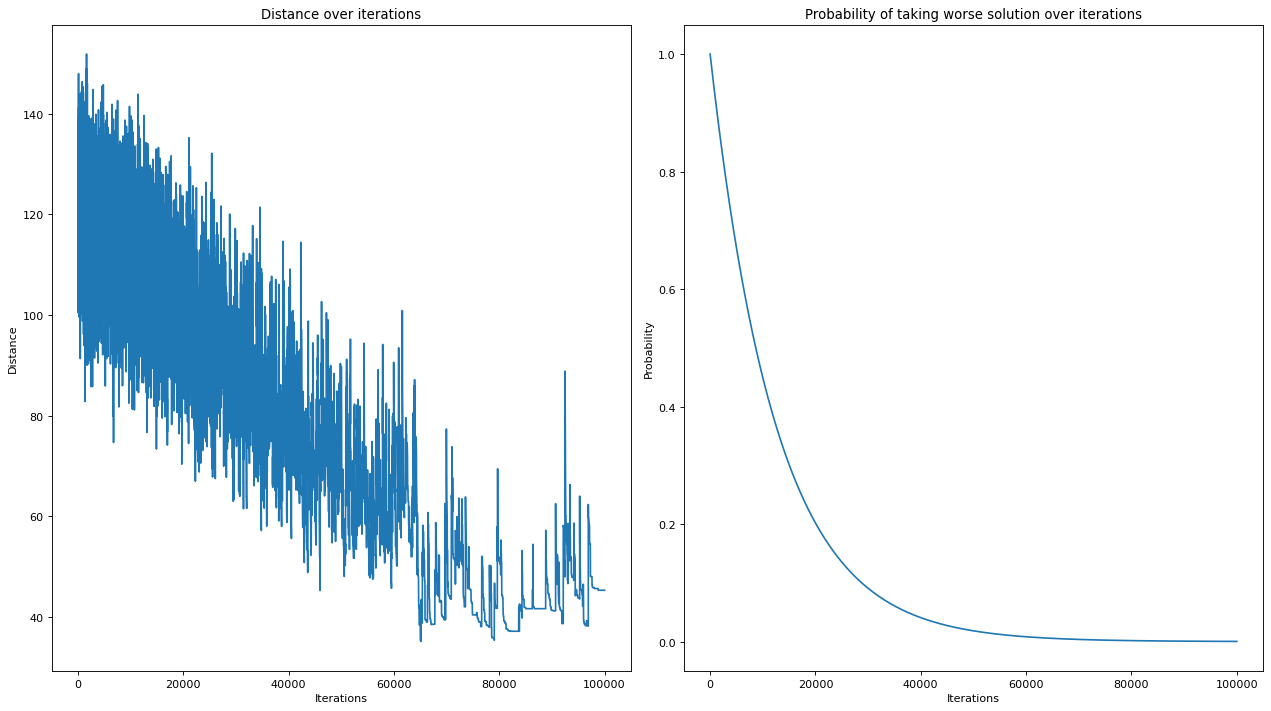

In [9]:
run_tsp(1, {'n': 27, 'groups': 9}, {'max_iterations': 10**5}, generation=generate_groups)

Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 45 punktów -> 9 grup po 5 punkty
4. $e^{-x}$ jako funkcja prawdopodobieństwa

SOLUTION IN INTERATION NUMBER: 1


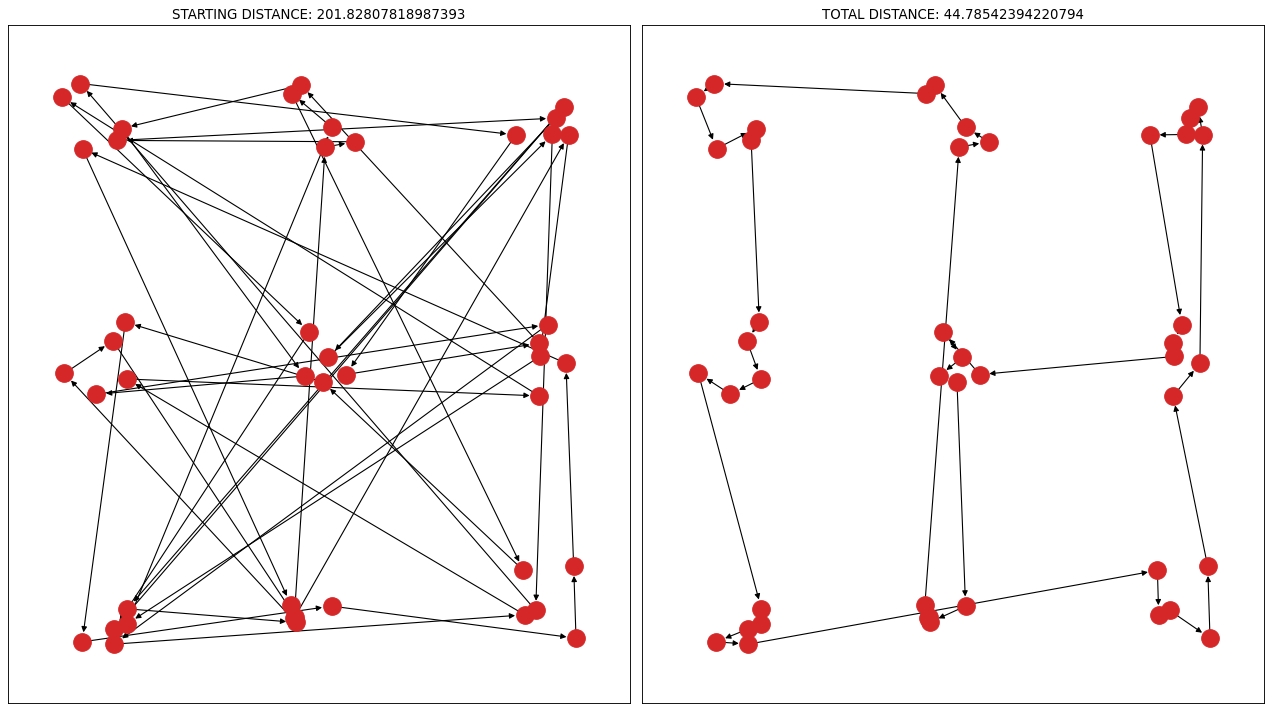

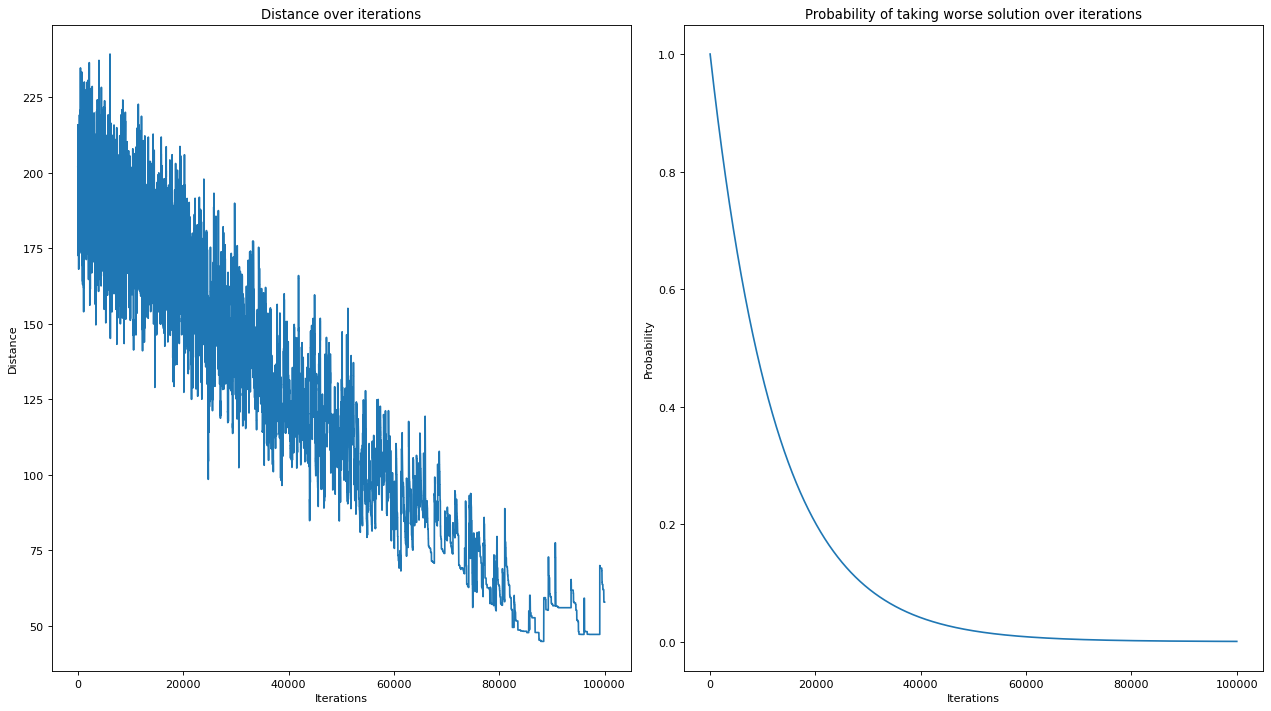

In [10]:
run_tsp(1, {'n': 45, 'groups': 9}, {'max_iterations': 10**5}, generation=generate_groups)

Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 90 punktów -> 9 grup po 10 punkty
4. $e^{-x}$ jako funkcja prawdopodobieństwa

SOLUTION IN INTERATION NUMBER: 1


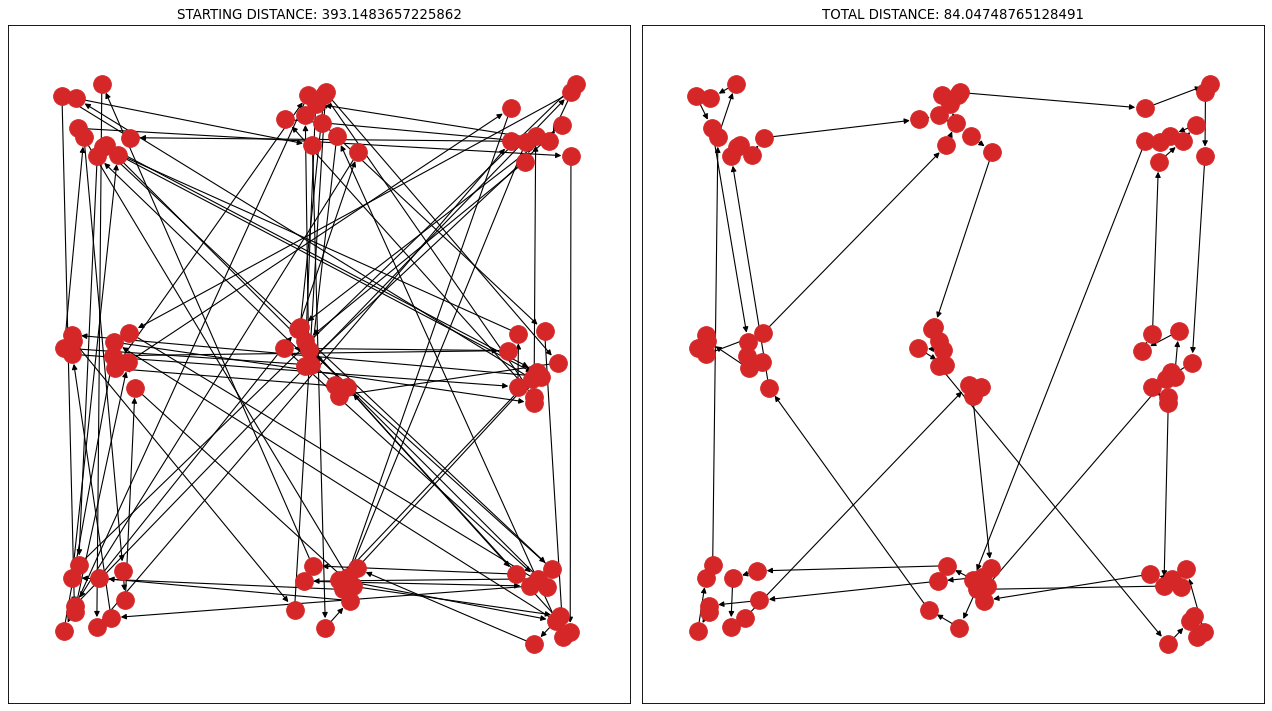

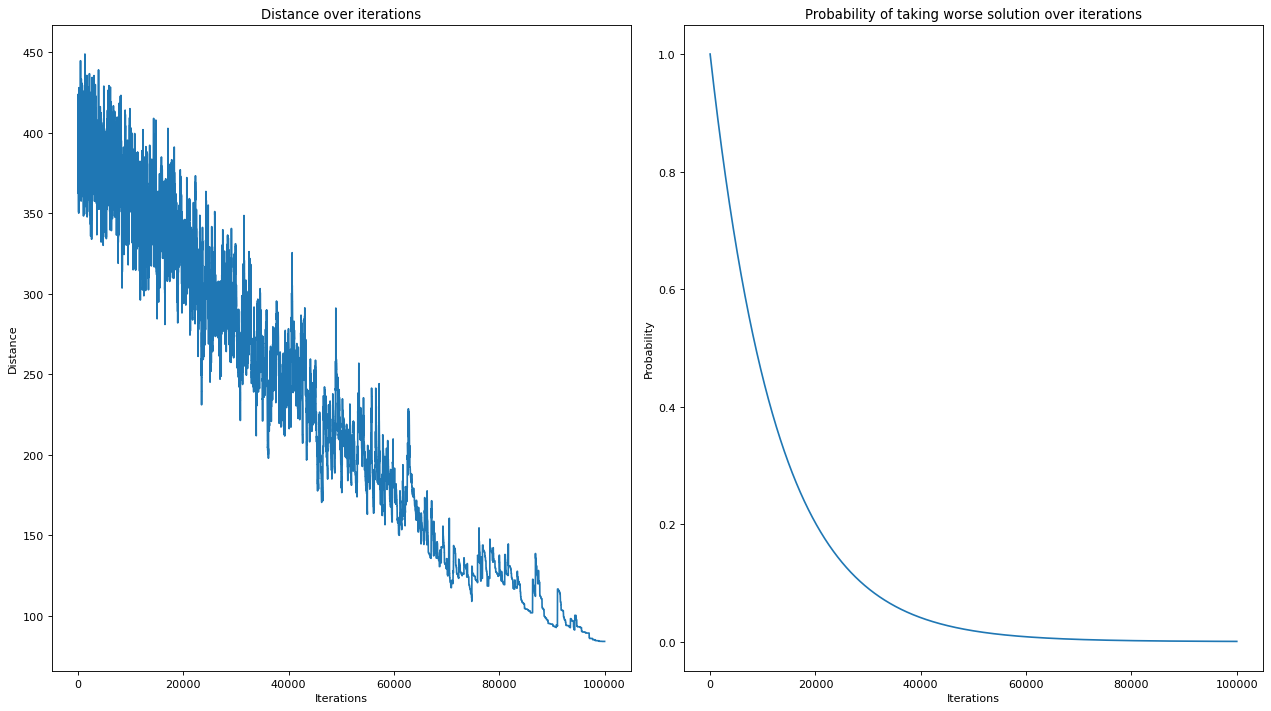

In [11]:
run_tsp(1, {'n': 90, 'groups': 9}, {'max_iterations': 10**5}, generation=generate_groups)

#### Rozkład normalny
Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 20 punktów
4. $e^{-x}$ jako funkcja prawdopodobieństwa

SOLUTION IN INTERATION NUMBER: 1


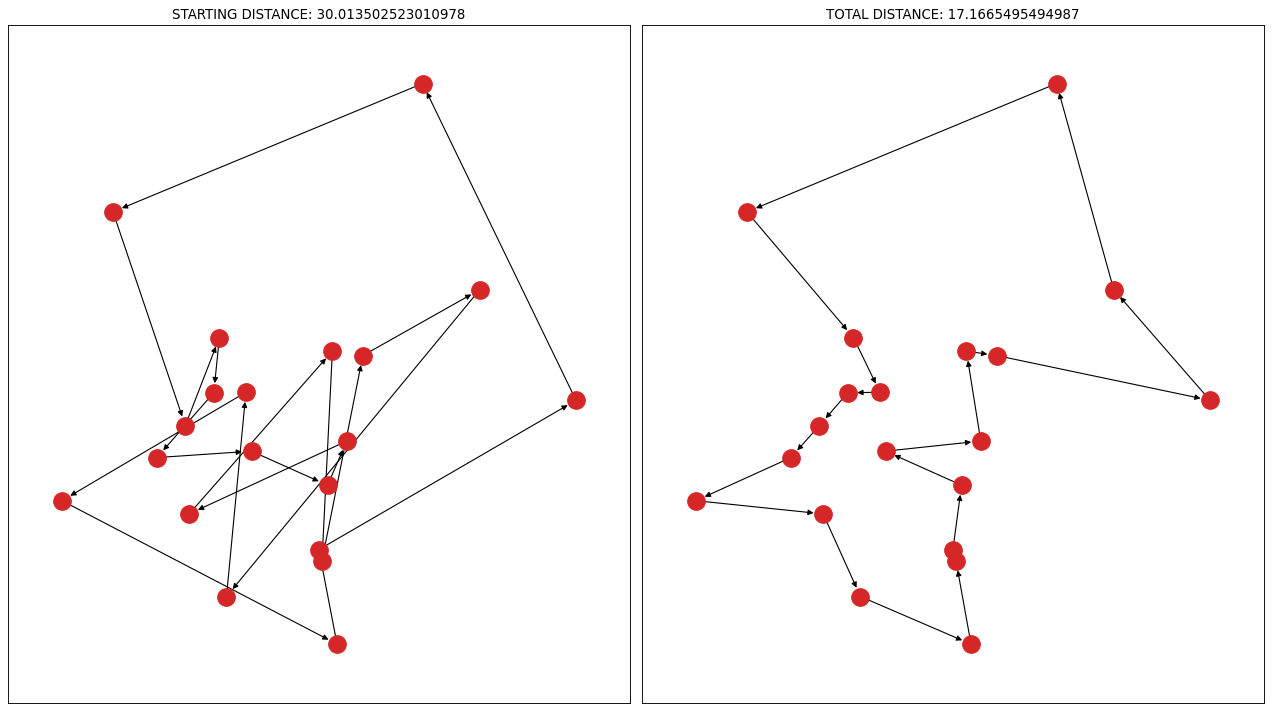

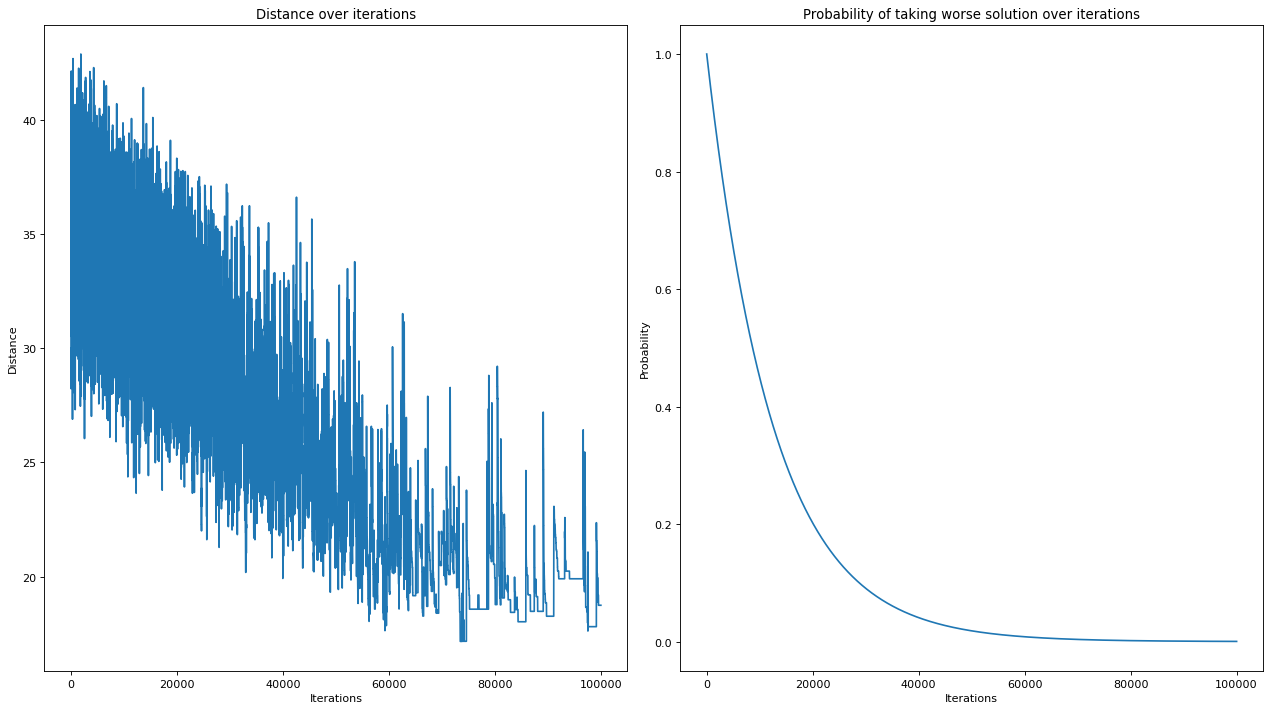

In [12]:
run_tsp(1, {'n': 20}, {'max_iterations': 10**5}, generation=generate_normal)

Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 50 punktów
4. $e^{-x}$ jako funkcja prawdopodobieństwa

SOLUTION IN INTERATION NUMBER: 1


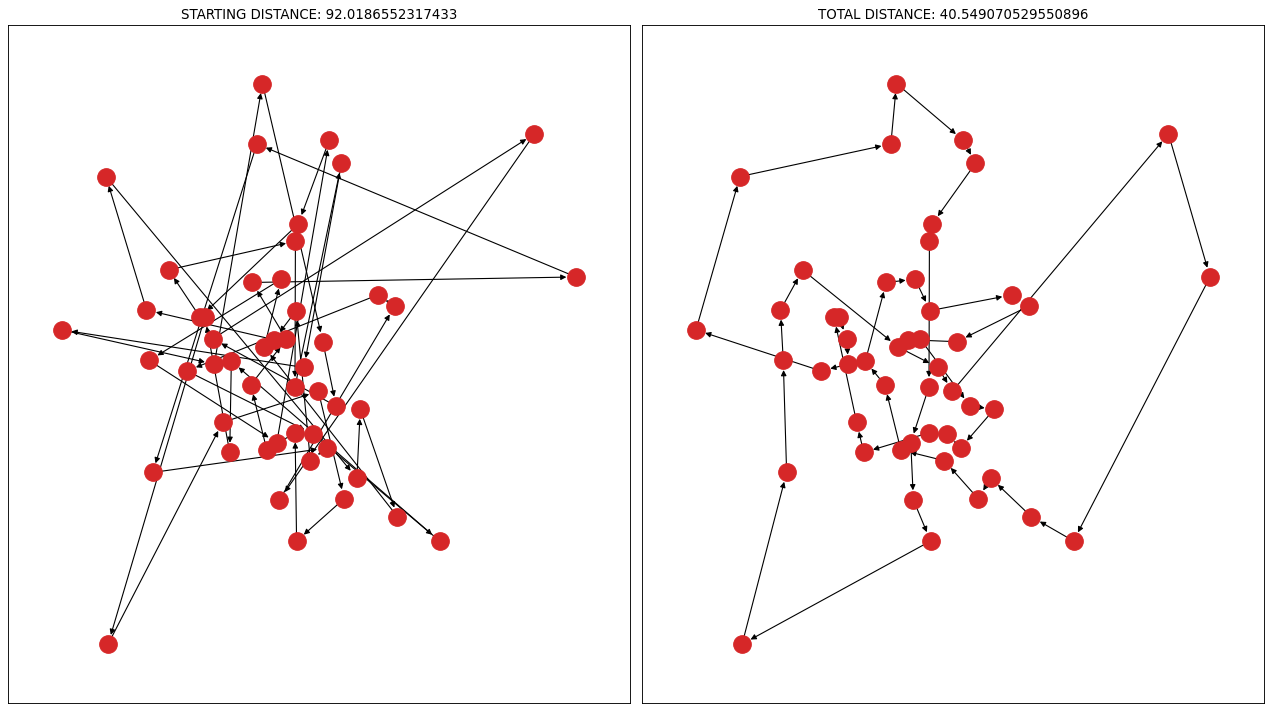

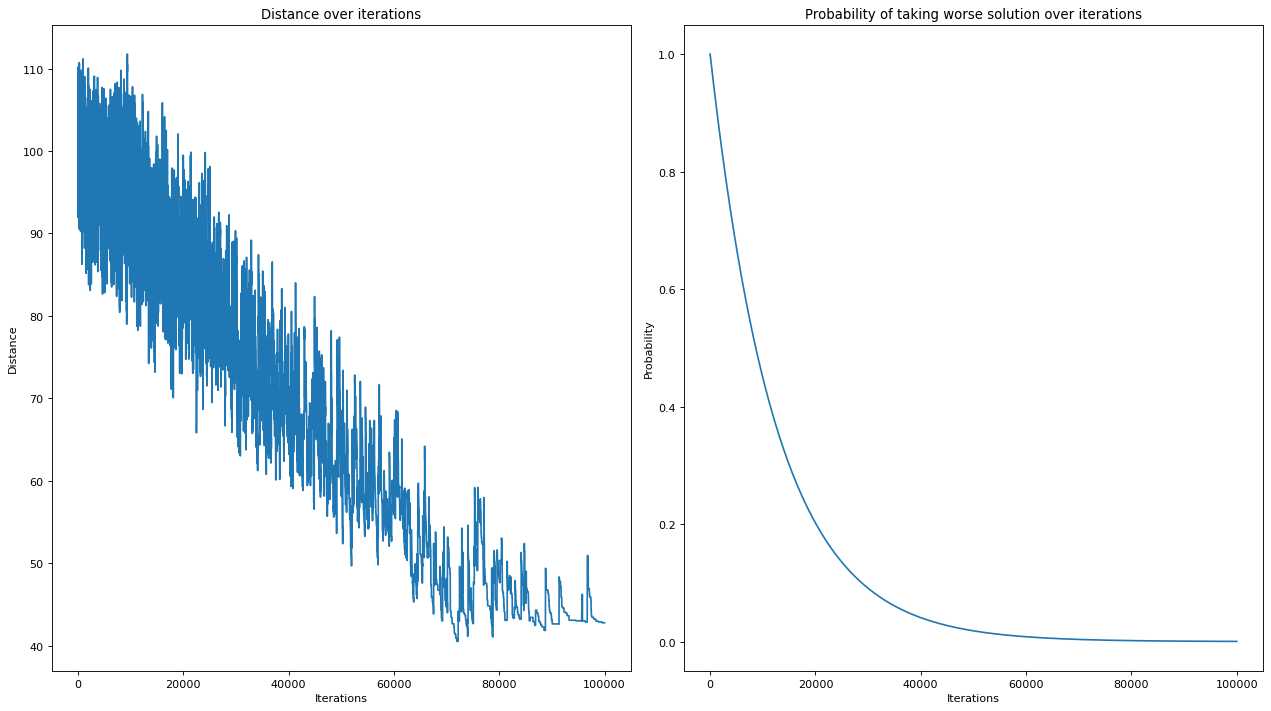

In [13]:
run_tsp(1, {'n': 50}, {'max_iterations': 10**5}, generation=generate_normal)

Dane wizualizowanego problemu:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 100 punktów
4. $e^{-x}$ jako funkcja prawdopodobieństwa

SOLUTION IN INTERATION NUMBER: 1


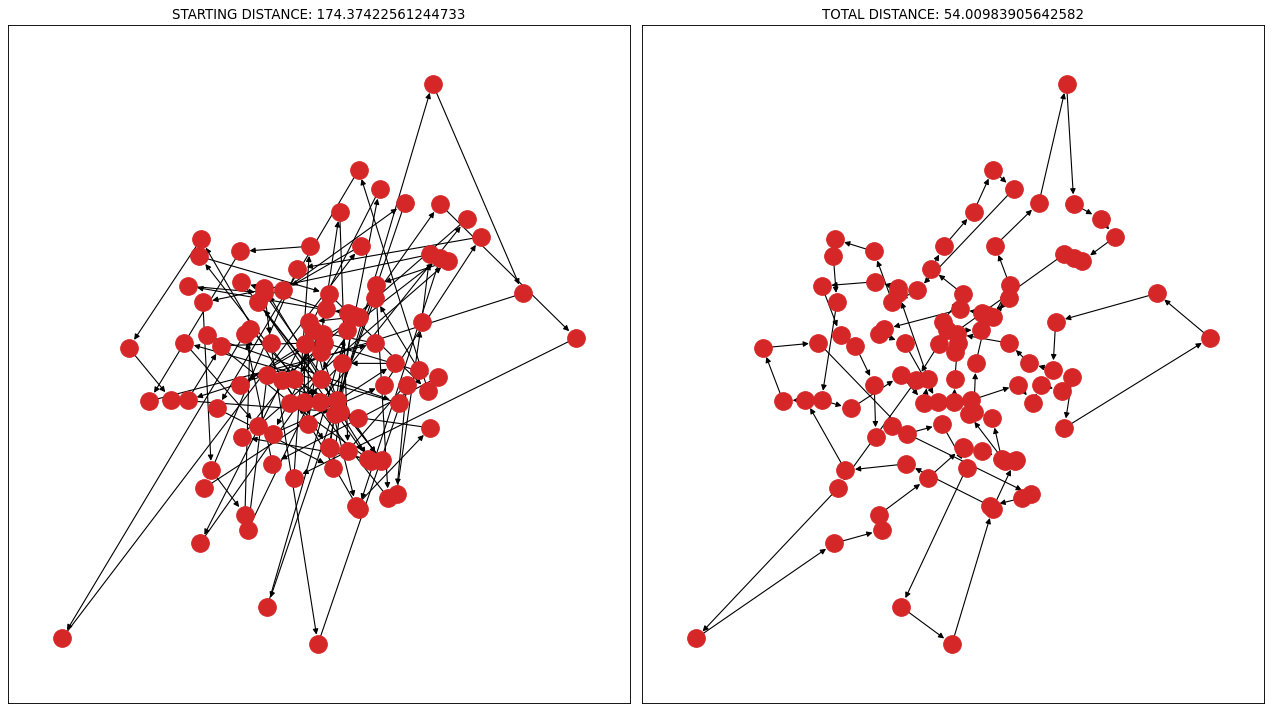

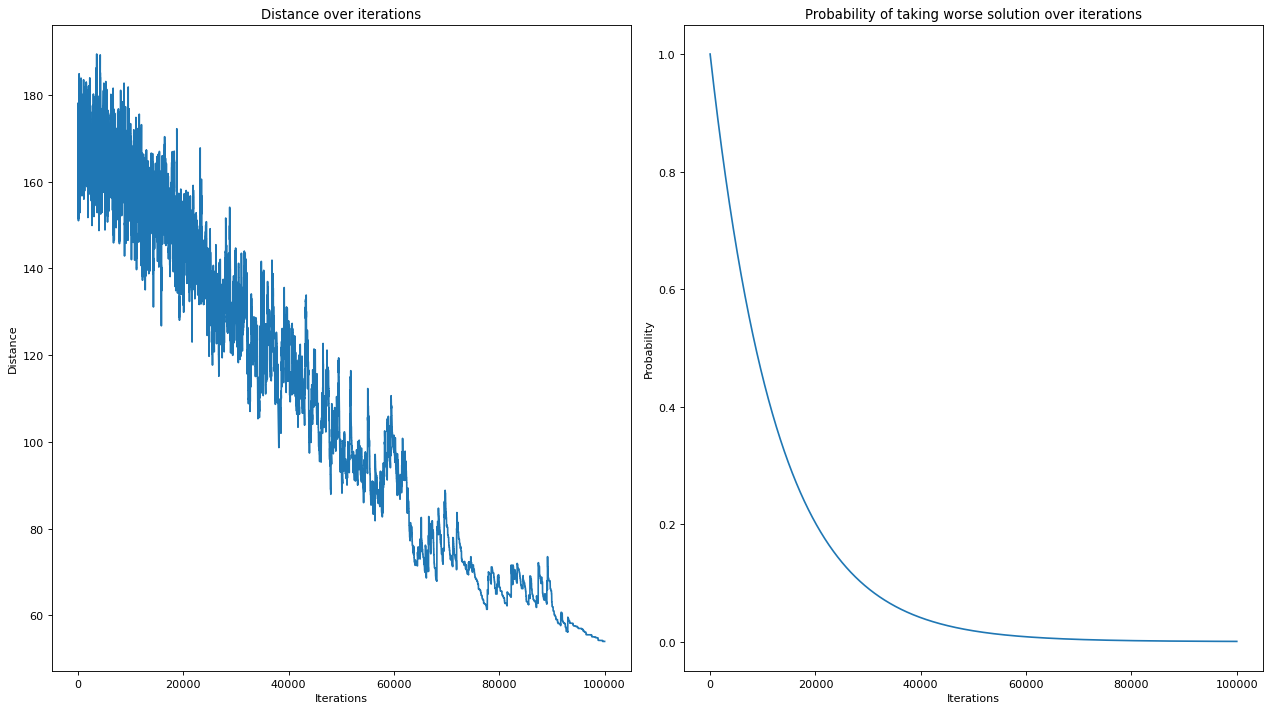

In [14]:
run_tsp(1, {'n': 100}, {'max_iterations': 10**5}, generation=generate_normal)

Wnioski:
1. Algorytm działa poprawnie dla małych n. Dla liczby wierzchołków ~> 20 wynik jest dobry, o wiele lepszy niż początkowy, ale nie jest optymalny (najłatwiej zaobserowwać to na grafach typu 9 grup)
2. W algorytmach stochastycznych należy zapamiętywać najlepsze rozwiązanie. Na niektórych wykresach `Distance over iterations` widać jak algorytm zmienia wynik na gorszy, lecz później nie daje rady do niego się zbliżyć (np 9 grup po 10 wierzchołków)
3. Algorytm należy uruchomić kilka razy (np. 5) i użyć najlepszego rozwiązania. Algorytmy stochastyczne potrafią 'zablokować się' w minimum lokalnym, przez co zwrócony wynik może być daleki od optymalnego


### 1.2  Wpływ sposobu generacji sąsiedniego stanu oraz funkcji zmiany temperatury na zbieżność procesu optymalizacji.

Sprawdzenie wpływu tych parametrów będzie testowane dla takich samych danych:
1. $10^5$ iteracji
2. 1 powtórzenie
3. 100 punktów o rozkładzie jednostajnym

Analizowane zostanie zachowanie algorytmu przy:
1. `consecutive swap` vs `arbitrary swap` (dwa losowe punkty vs losowy punkt i jego następnik)
2. liniowia vs eksponencjalna funkcja prawdopodobieństwa


#### Eksponencjalna funkcja i arbitrary swap

SOLUTION IN INTERATION NUMBER: 1


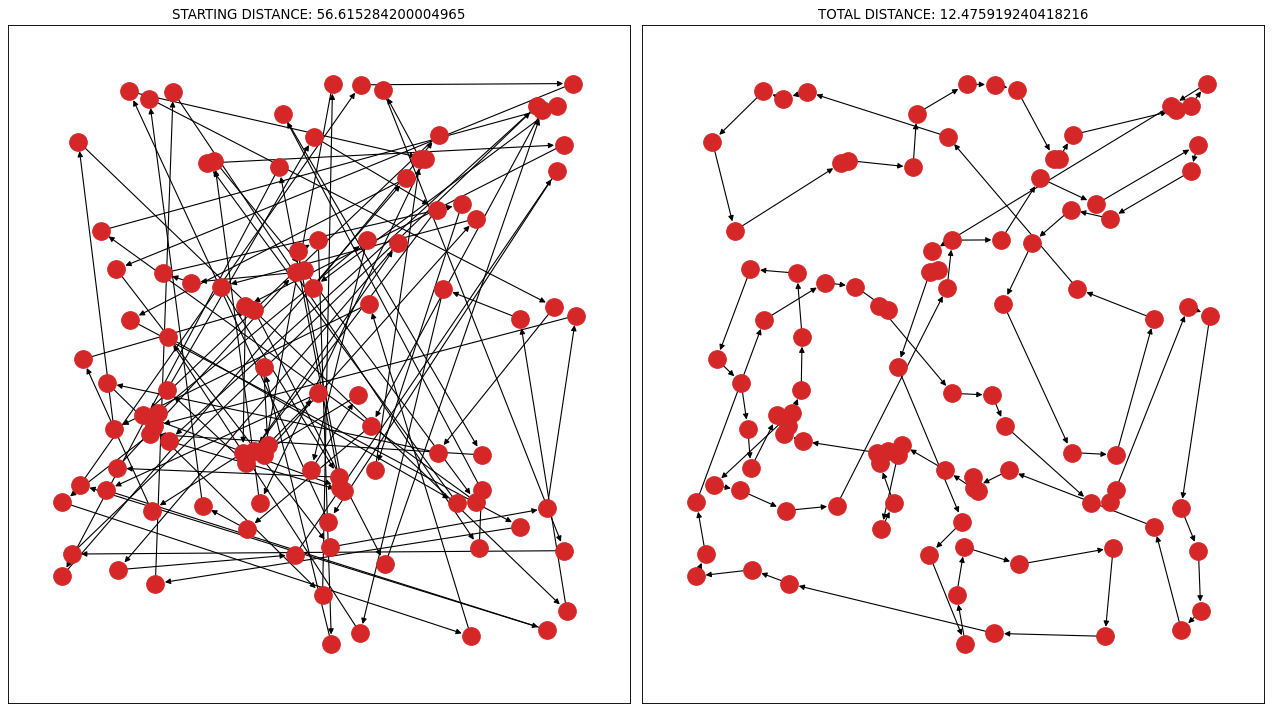

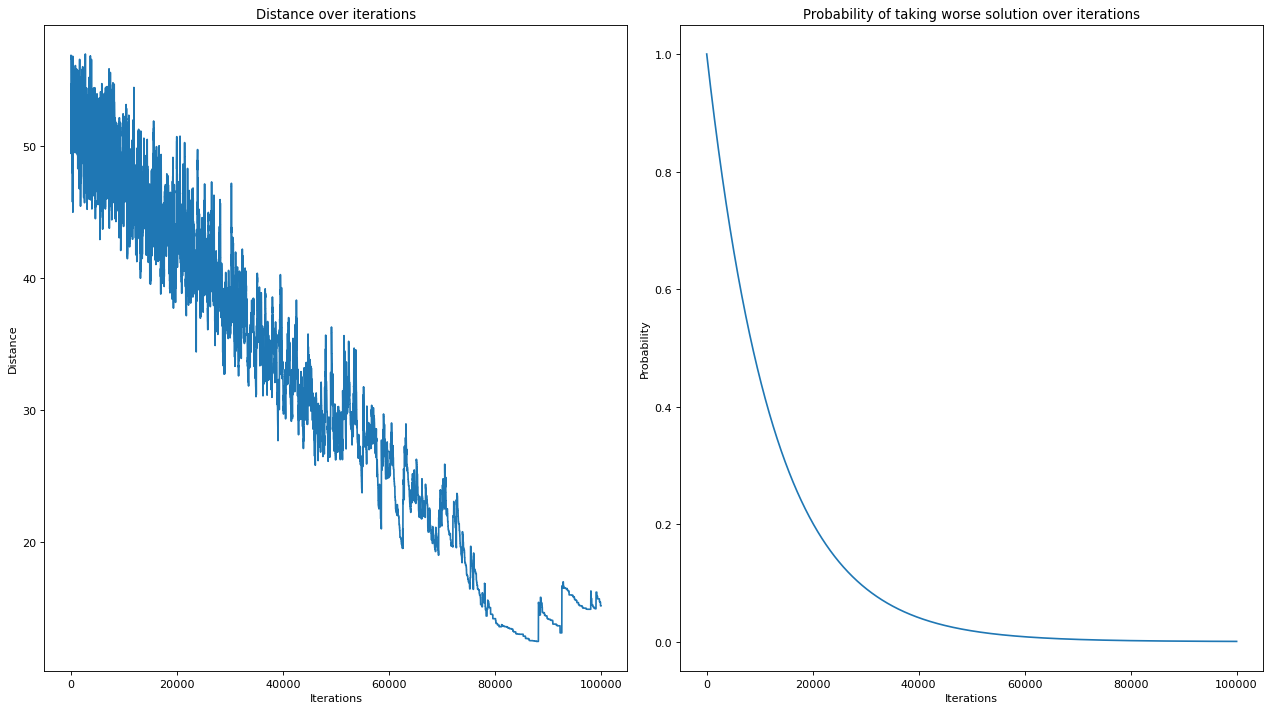

In [15]:
run_tsp(1, {'n': 100}, {'max_iterations': 10**5}, seed=100)

#### Liniowa funkcja i arbitrary swap

SOLUTION IN INTERATION NUMBER: 1


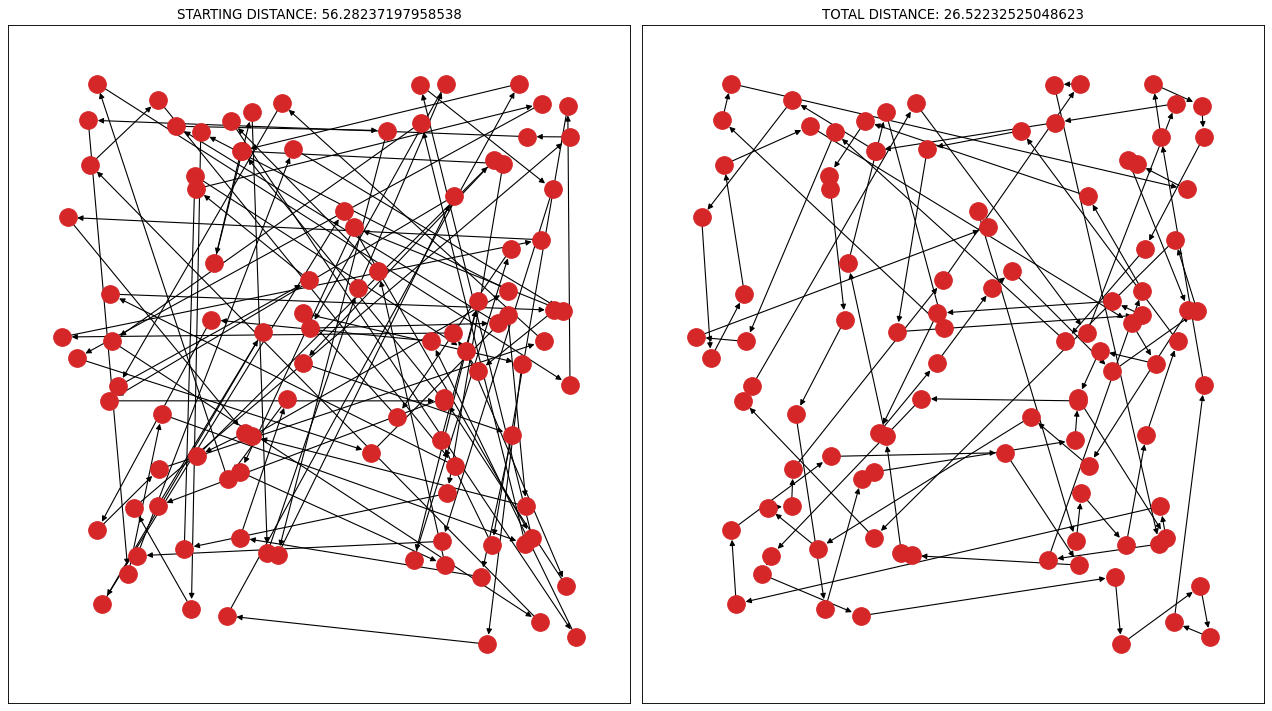

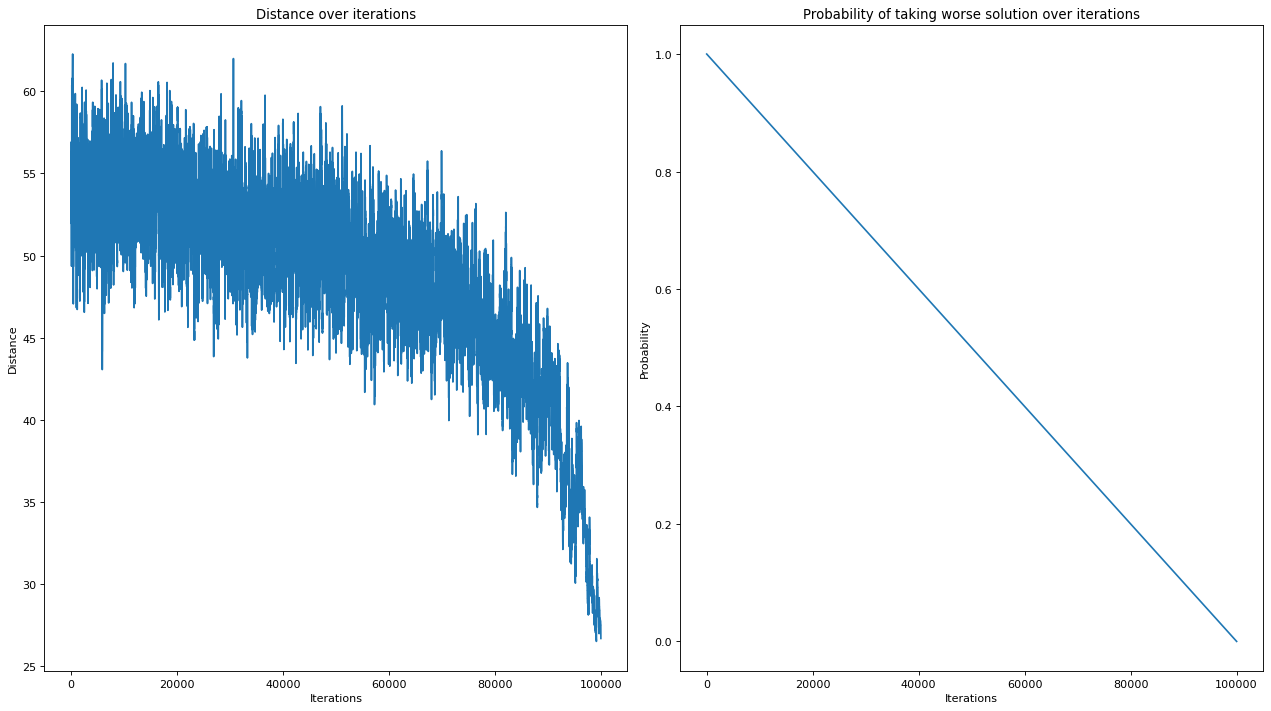

In [16]:
run_tsp(1, {'n': 100}, {'max_iterations': 10**5}, linear=True)

#### Eksponencjalna funkcja i consecutive swap

SOLUTION IN INTERATION NUMBER: 1


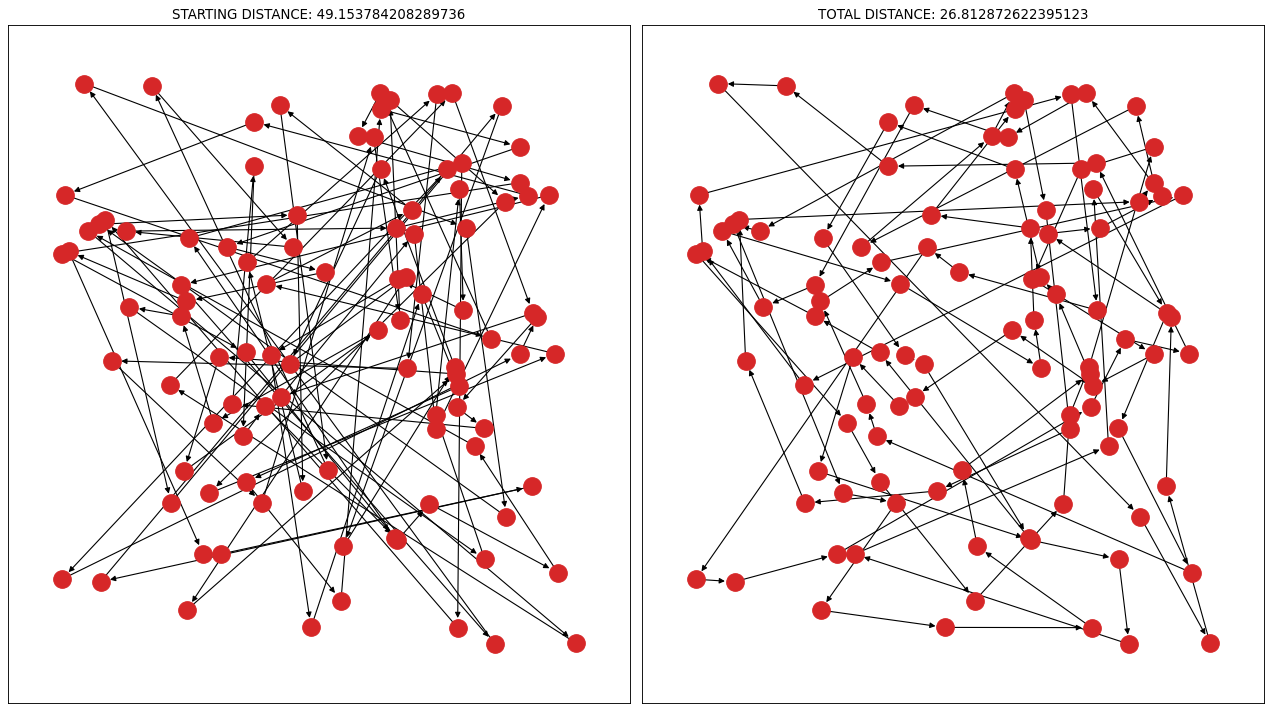

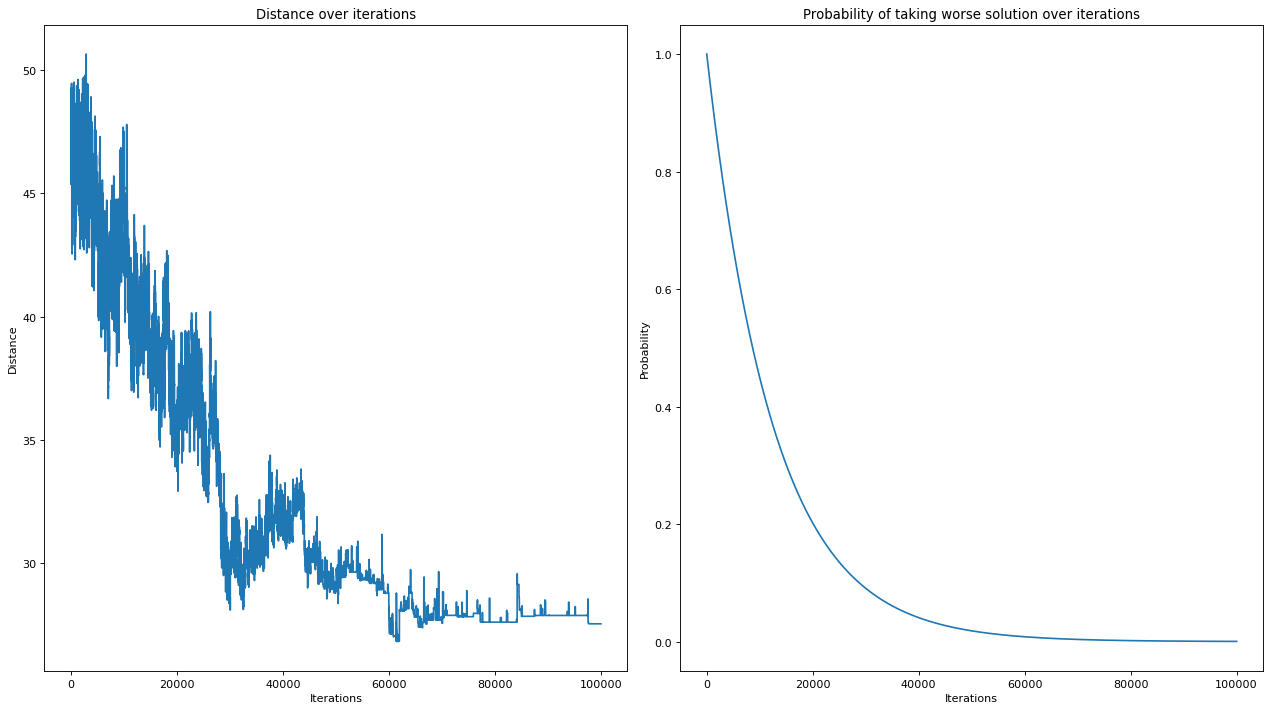

In [17]:
run_tsp(1, {'n': 100}, {'max_iterations': 10**5}, seed=20, consecutive_swap=True)

#### Liniowa funkcja i consecutive swap

SOLUTION IN INTERATION NUMBER: 1


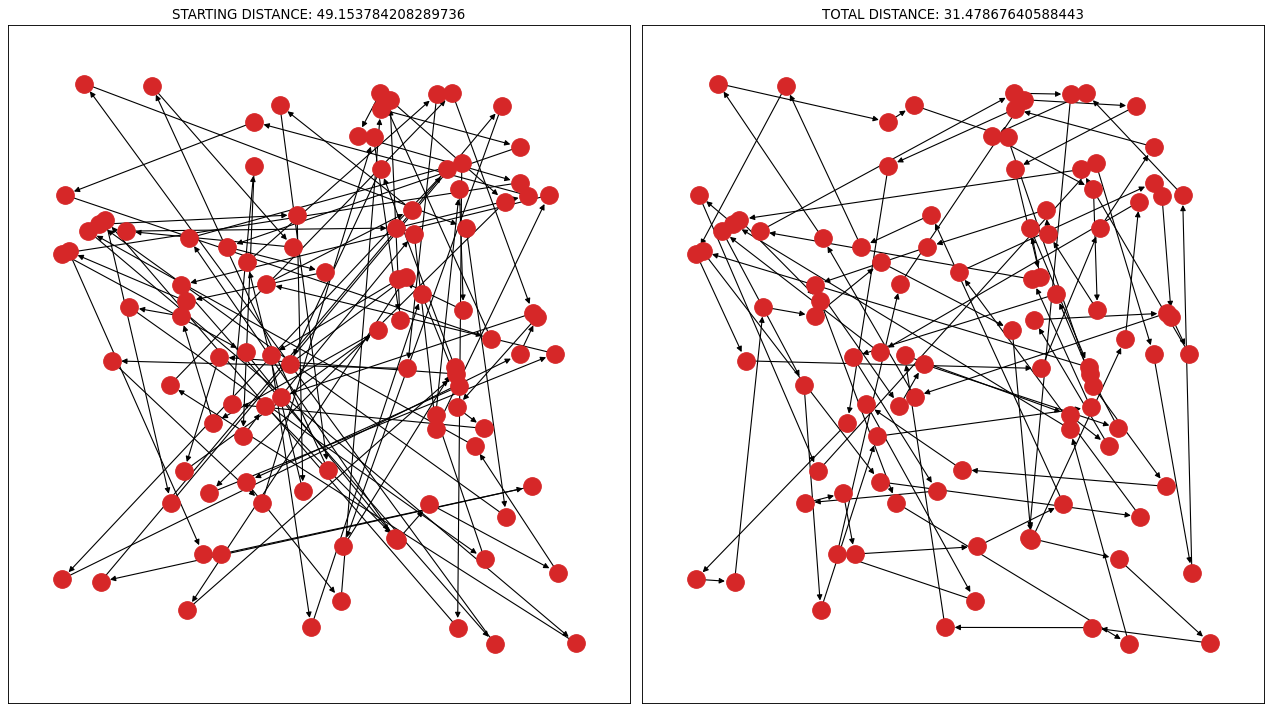

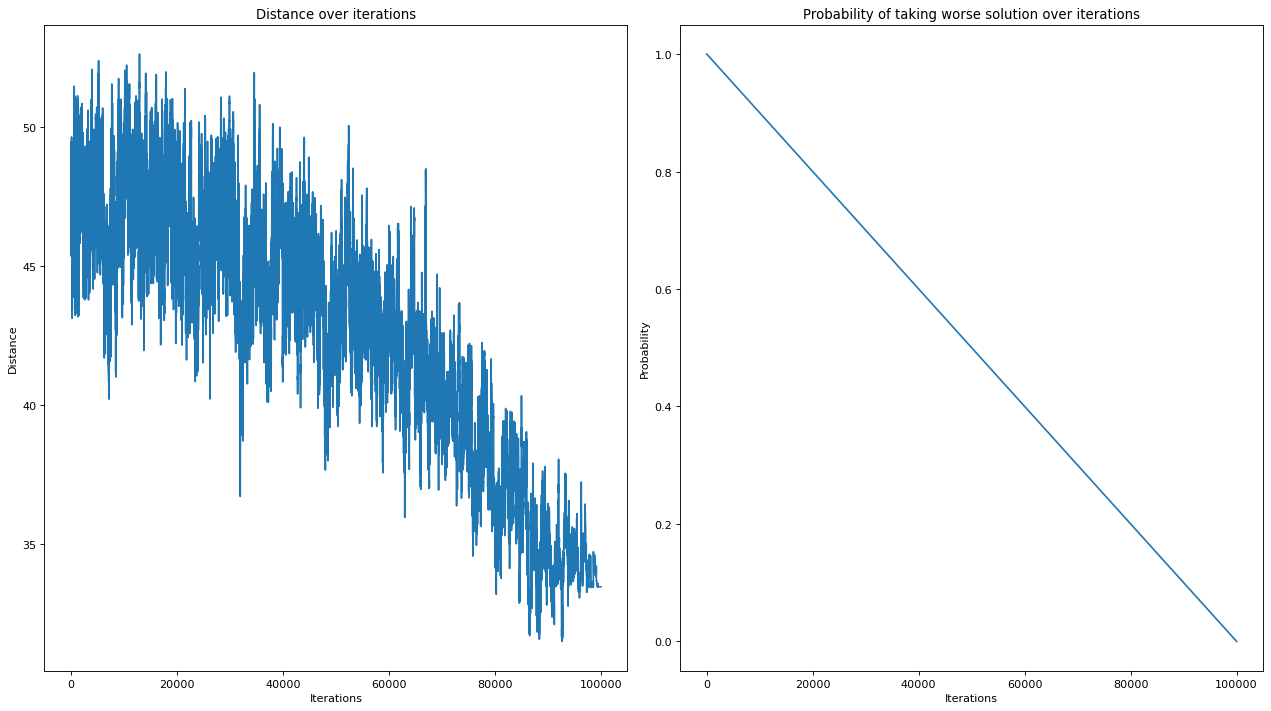

In [18]:
run_tsp(1, {'n': 100}, {'max_iterations': 10**5} ,seed=20, linear=True, consecutive_swap=True)

Wnioski:
1. Funkcja liniowa daje zdecydowanie gorsze rezultaty niż eksponencjalna (w eksponencjalnej o wiele szybciej ogarniczamy możliwość wybrania gorszego rozwiązania)
2. `Consecutive swap` jest gorsze niż `arbitrary swap`. Widać to wyraźnie porównując 'taktyki' na tle funkcji eksponencjalnej oraz liniowej. W przypadku funkcji liniowej zmieniony został `seed` na 20, ponieważ przy wartości równej 100 oraz `arbitrary swap` algorytm blokował się - nie potrafił wyjść z minimum lokalnego.


### 1.2b Wpływ minimalnej temperatury na zbieżność procesu optymalizacji przu użyciu funkcji eksponencjalnej.

Zaimplementowana funkcja eksponencjalna zawsze daje prawdopodobieństwo od 1 do 0. Jej jedynym parametrem jest min_temp (musi być ujemna), która definiuje 'stromość' funkcji.

Analizowane zostanie wpływ tego parametru na wynik funkcji

#### Łagodna funkcja temperatury

SOLUTION IN INTERATION NUMBER: 1


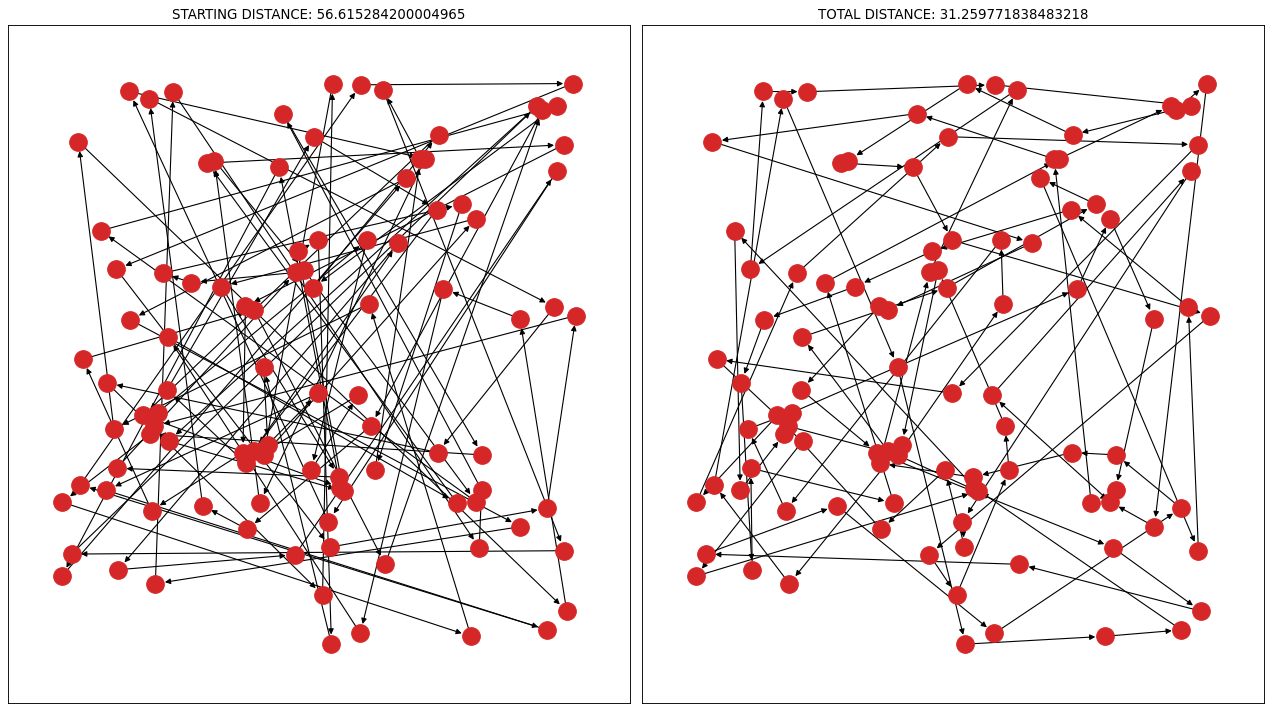

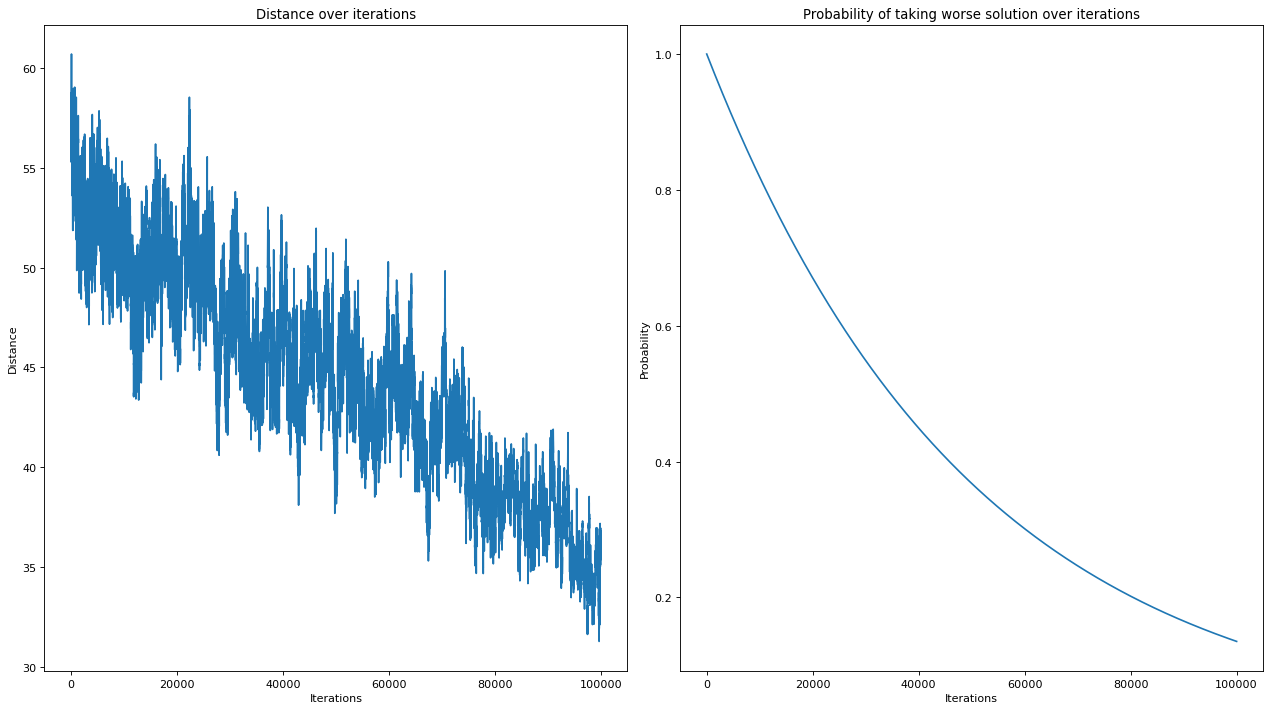

In [19]:
run_tsp(1, {'n': 100}, {'max_iterations': 10**5}, seed=100, consecutive_swap=True, min_temp= -2)

#### Stroma funkcja temperatury

SOLUTION IN INTERATION NUMBER: 1


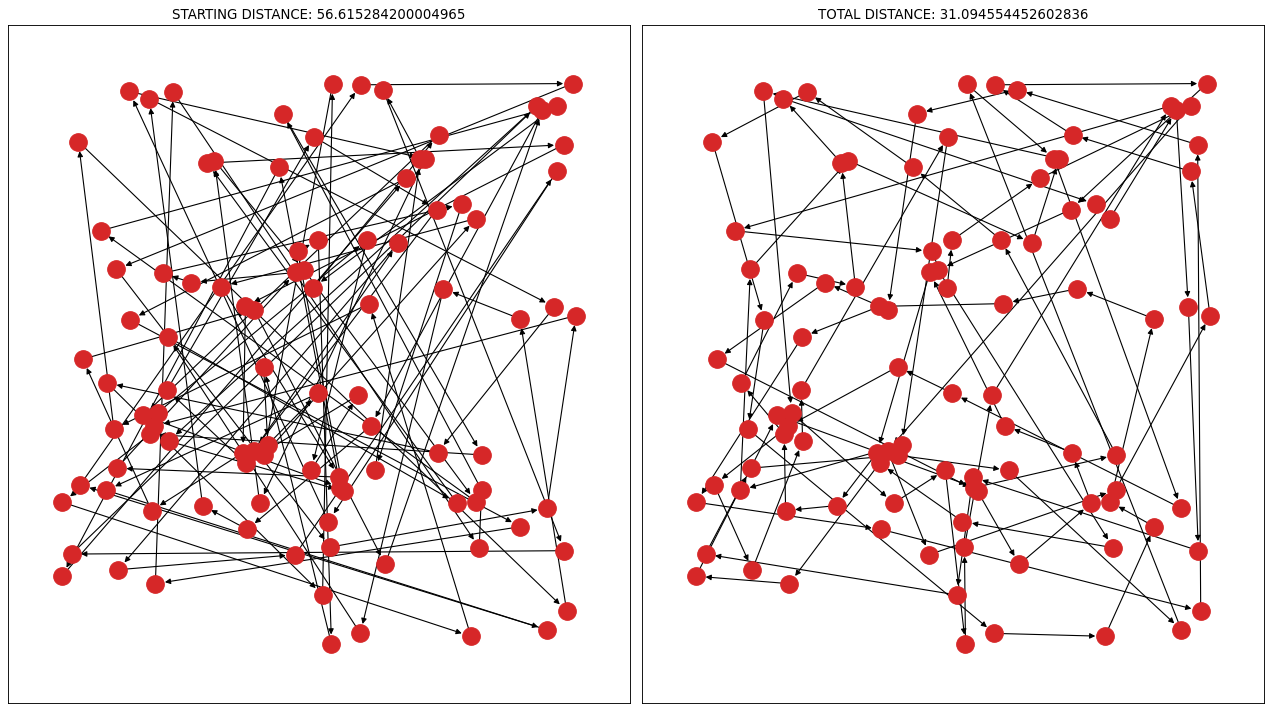

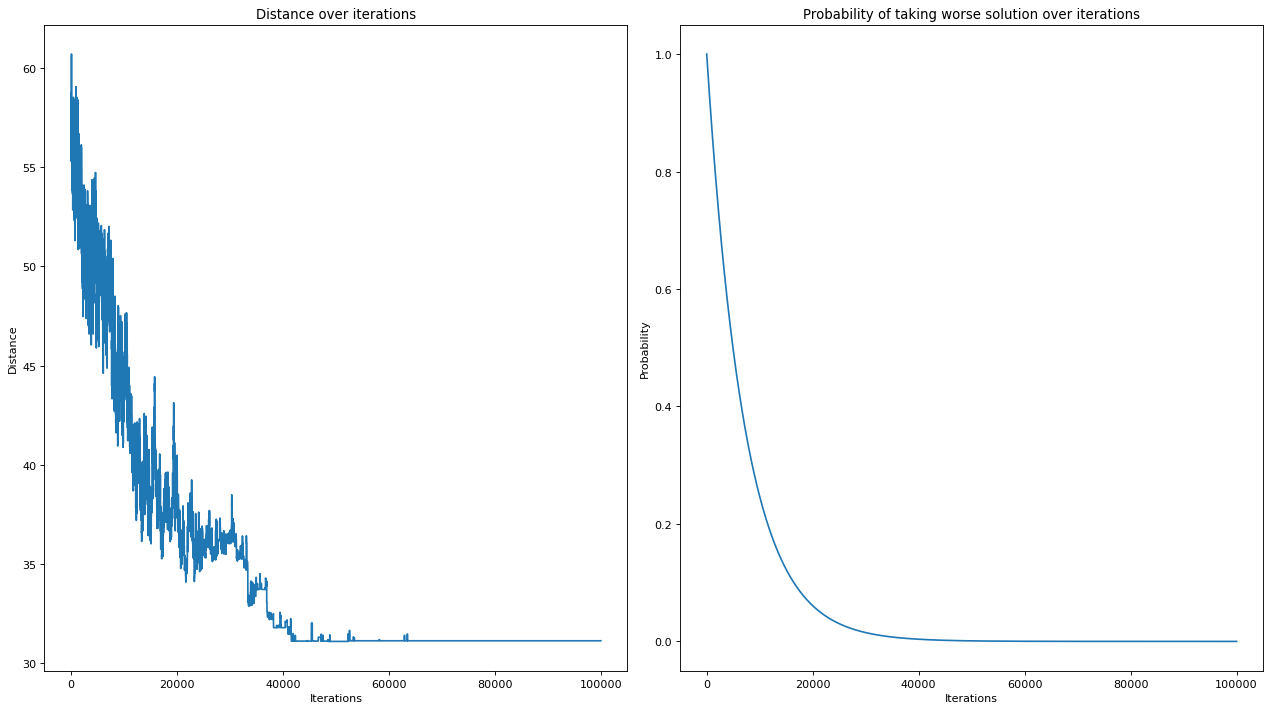

In [20]:
run_tsp(1, {'n': 100}, {'max_iterations': 10**5}, seed=100, consecutive_swap=True, min_temp=-14)

Wnioski:
1. Funkcja eksponencjalna daje dobre wyniki, tylko gdy jej stromość jest odpowiednia. Taki sam przykład rozwiązany był w `1.2 Eksponencjalna funkcja i arbitrary swap`. Tamtejszy wynik jest ponad 2 razy mniejszy od powyższych! Defaultowa wartość `min_temp` to -8, właśnie wtedy stromość funkcji jest odpowiednia.
2. Zbyt stroma funkcja sprawia, że nie można wyjść z minimum lokalnego - w pewnym momencie zostaje to niemalże zablokowane
3. Zbyt łagodna funkcja nie potrafi ustabilizować się - cały czas jest duże prawdopodobieństwo ustawienia gorszego wyniku, więc nie da się go znacząco poprawić

### 1.3 Wizualizacja działania procedury minimalizujacej funkcje celu.

We wcześniejszych podpunktach, przy każdym użyciu funkcji run() rysowane były funkcje prawdopodobieństwa wraz z funkcją dystansu od czasu (czyli funkcją celu).
Bardzo dobrze pokazują zachowanie algorytmu, co przyczyniło się do łatwego wnioskowania.


## 2. Obraz binarny
zadanie otwrate, definiujemy wlasne zasady fizyki. testujemy rozne rodzaje sasiedztwa 6 albo i więcej. Liczymy energie potencjalne np. suma czarnych sąsiadów. Energia potencjalna jest im wieksza tym bardziej czegoś nie chcemy. Np czarny chce być z białymi to energia to ilość czarnych sąsiadów. Macierz ma być duża min 256/256. Ma być stała liczba czarnych punktów, Optymalizujemy tak aby wykres wyżarzania był spoko. O ocenie za to zadanie decyduje ilość ciekawych rozwiązań. SPR przy tym samym ukłądzie i funkcji energi i sąsiedztwie jak sie zmieni w stosunku do zmiany funkcji temperatury

OPPPPPPPPPPPPIS

### Funkcja generowania obrazu binarnego

In [21]:
def generate_binary(n=256, p=0.1, seed=100):
    A_1D = np.zeros((n*n))

    last_one_id = round(n*n*p)
    A_1D[:last_one_id] += 1

    np.random.seed(seed)
    np.random.shuffle(A_1D)

    A_2D = np.reshape(A_1D, (n,n))

    return A_2D


### Struktury użyte w rozwiązaniu:
1) Temperature - klasa wykorzystywana do obsługi funkcji temperatury
2) Annealing - abstrakcyjna klasa po której dziedziczy BinaryImage
3) BinaryImage - klasa minimalizująca energię potencjalną obrazu
4) Energy - klasa abstrakcyjna po której dziedziczą wszystkie klasy sąsiedztwa
5) FourNeighbour, FourNeighbourCrossed, AroundCell, Row, Col, RowAndCol - klasy sąsiedztwa

In [22]:
class Energy(ABC):
    def __init__(self, energy_fun=lambda x: x * math.sqrt(x) if x>0 else 0):
        self._energy_fun = energy_fun
        super().__init__()

    @property
    def energy_func(self):
        return self._energy_fun

    def calculate_energy(self, matrix: np.ndarray, r: int, c: int):
        neighbours = self.get_neighbours(matrix, r, c)
        neighbours_num = sum([matrix[neighbour] for neighbour in neighbours])
        return self._energy_fun(neighbours_num)

    @abstractmethod
    def get_neighbours(self, matrix: np.ndarray, r: int, c: int):
        pass

    def calculate_active_neighbours(self, matrix: np.ndarray, r: int, c: int):
        neighbours = self.get_neighbours(matrix, r, c)
        return sum(map(lambda cords: matrix[cords[0], cords[1]], neighbours))

class FourNeighbour(Energy):
    def get_neighbours(self, matrix: np.ndarray, r: int, c: int):
        n = len(matrix)
        return [(int((r+1) % n), c), (r, int((c+1) % n)), (int((r-1) % n), c), (r, int((c-1) % n))]

class FourNeighbourCrossed(Energy):
    def get_neighbours(self, matrix: np.ndarray, r: int, c: int):
        n = len(matrix)
        return [(int((r+1) % n) , int((c+1) % n)), (int((r-1) % n), int((c+1) % n)), (int((r-1) % n), int((c-1) % n)), (int((r+1) % n), int((c-1) % n))]

class AroundCell(FourNeighbour, FourNeighbourCrossed):
    def get_neighbours(self, matrix: np.ndarray, r: int, c: int):
        return FourNeighbour.get_neighbours(self, matrix, r, c) + FourNeighbourCrossed.get_neighbours(self, matrix, r, c)

class Row(Energy):
    def get_neighbours(self, matrix: np.ndarray, r: int, c: int):
        row = [(r,i) for i in range(len(matrix)) if i != c]
        return row

    def calculate_energy(self, matrix: np.ndarray, r: int, c: int):
        neighbours_num = np.sum(matrix[r]) - matrix[r, c]
        return self._energy_fun(neighbours_num)

class Col(Energy):
    def get_neighbours(self, matrix: np.ndarray, r: int, c: int):
        col = [(i,c) for i in range(len(matrix)) if i != r]
        return col

    def calculate_energy(self, matrix: np.ndarray, r: int, c: int):
        neighbours_num = np.sum(matrix[:, c]) - matrix[r, c]
        return self._energy_fun(neighbours_num)

class RowAndCol(Row, Col):
    def get_neighbours(self, matrix: np.ndarray, r: int, c: int):
        return Row.get_neighbours(self, matrix, r, c) + Col.get_neighbours(self, matrix, r, c)


class BinaryImage(Annealing):
    def __init__(self, image: np.ndarray, max_iterations: int, **kwargs):
        super().__init__(max_iterations)
        self.neighbourhoods = {"four": self.use_four_neighbours, "four_crossed": self.use_four_neighbours_crossed, "around": self.use_around_cell,
                               "row": self.use_row, "col": self.use_col, "row_and_col": self.use_row_and_col}
        self._image = np.copy(image)
        self._n = len(image)
        self._best_image = np.copy(image)
        self._starting_order = np.copy(image)
        if "neighbourhood" in kwargs:
            self._use_given_neighbourhood(kwargs["neighbourhood"])
        else:
            self._energy = None
            self._neighbours_matrix = None
            self._best_energy = None
            self._starting_energy = None

    def set(self, image: np.ndarray, max_iterations: int, **kwargs):
        self._reset(max_iterations)
        self._image = np.copy(image)
        self._n = len(image)
        self._best_image = np.copy(image)
        self._starting_order = np.copy(image)
        if "neighbourhood" in kwargs:
            self._use_given_neighbourhood(kwargs["neighbourhood"])
        else:
            self._energy = None
            self._neighbours_matrix = None
            self._best_energy = None
            self._starting_energy = None

    def _use_given_neighbourhood(self, neighbourhood: str):
        if neighbourhood not in self.neighbourhoods:
            raise Exception("Wrong neighbourhood given!")

        self.neighbourhoods[neighbourhood]()

    def calculate_beginning_energies(self):
        self._neighbours_matrix = self._calculate_neighbours()
        vfunc = np.vectorize(self._calculate_energy)
        self._best_energy = np.sum(vfunc(self._neighbours_matrix))
        self._starting_energy = self._best_energy

    def use_four_neighbours(self):
        self._energy = FourNeighbour()
        self.calculate_beginning_energies()

    def use_four_neighbours_crossed(self):
        self._energy = FourNeighbourCrossed()
        self.calculate_beginning_energies()

    def use_around_cell(self):
        self._energy = AroundCell()
        self.calculate_beginning_energies()

    def use_row(self):
        self._energy = Row()
        self.calculate_beginning_energies()

    def use_col(self):
        self._energy = Col()
        self.calculate_beginning_energies()

    def use_row_and_col(self):
        self._energy = RowAndCol()
        self.calculate_beginning_energies()

    def solve(self):
        if self._is_used:
            raise Exception("Use .set() to use it again")

        curr_energy = self._best_energy
        self._results_over_time.append(curr_energy)
        for step in range(1, self._max_iterations+1):
            index1, index2 = np.random.choice(np.arange(self._n**2), 2)
            if self._consecutive_swap:
                index2 = (index1 + 1) % (self._n**2)

            cords1, cords2 = (int(index1 // self._n), int(index1 % self._n)), (int(index2 // self._n), int(index2 % self._n))
            energy_difference = self._calculate_difference(cords1, cords2)

            random = np.random.random()
            if energy_difference > 0 or random < self._temp.probability:
                self._change_cords(cords1, cords2)
                curr_energy -= energy_difference

            if curr_energy < self._best_energy:
                self._best_energy = curr_energy
                self._best_image = np.copy(self._image)

            self._temp.cool_down()
            self._results_over_time.append(curr_energy)

        self._is_used = True
        self._image = self._best_image

    def _change_cords(self, c1: Tuple[int,int], c2: Tuple[int, int]):
        if self._image[c1] == self._image[c2]:
            return

        neighbours1 = self._energy.get_neighbours(self._image, c1[0], c1[1])
        neighbours2 = self._energy.get_neighbours(self._image, c2[0], c2[1])

        change = 1 if self._image[c1] == 0 else -1
        for neighbour in neighbours1:
            self._neighbours_matrix[neighbour] += change

        for neighbour in neighbours2:
            self._neighbours_matrix[neighbour] -= change

        if c1 in neighbours2:
            self._neighbours_matrix[c1] -= change
            self._neighbours_matrix[c2] += change

        self._image[c1], self._image[c2] = self._image[c2], self._image[c1]

    def _calculate_difference(self, c1: Tuple[int,int], c2: Tuple[int, int]):
        if self._image[c1] == self._image[c2]:
            return 0

        neighbours1 = self._energy.get_neighbours(self._image, c1[0], c1[1])
        neighbours2 = self._energy.get_neighbours(self._image, c2[0], c2[1])

        common_neighbours = set(neighbours1).intersection(neighbours2)
        neighbours1 = [neighbour for neighbour in neighbours1 if neighbour not in common_neighbours]
        neighbours2 = [neighbour for neighbour in neighbours2 if neighbour not in common_neighbours]
        results = list(map(lambda x: self._calculate_energy(self._neighbours_matrix[x]), itertools.chain(neighbours1, neighbours2)))
        before_change = sum(results)

        change = 1 if self._image[c1] == 0 else -1

        after_change = sum(map(lambda x: self._calculate_energy(self._neighbours_matrix[x] + change), neighbours1)) +\
                       sum(map(lambda x: self._calculate_energy(self._neighbours_matrix[x] - change), neighbours2))

        # When chosen points are neighbours, the is a need to consider their energy change
        if c1 in neighbours2:
            before_change += self._energy.energy_func(self._neighbours_matrix[c1]) + \
                             self._energy.energy_func(self._neighbours_matrix[c2])
            after_change += self._energy.energy_func(self._neighbours_matrix[c1] - change) +\
                            self._energy.energy_func(self._neighbours_matrix[c2] + change)

        return before_change - after_change

    def _calculate_neighbours(self):
        active_neighbours = lambda i,j: self._energy.calculate_active_neighbours(self._image, i, j)
        neighbours = np.ndarray((self._n, self._n))
        for r in range(self._n):
            for c in range(self._n):
                neighbours[r,c] = active_neighbours(r,c)

        return neighbours


    def _calculate_energy(self, neighbours_num: int):
        return self._energy.energy_func(neighbours_num)

    def draw_starting_and_ending_graph(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9), dpi=80)
        self.draw(ax = ax1, starting_binary=True)
        self.draw(ax = ax2)
        fig.tight_layout()
        plt.show()

    def draw(self, node_size=5, ax=None, starting_binary=False):
        if ax:
            p = ax
        else:
            plt.figure(figsize=(20, 15), dpi=80)
            p = plt

        image = self._starting_order if starting_binary else self._image
        title = "STARTING ENERGY" if starting_binary else "FINAL ENERGY"
        energy = self._starting_energy if starting_binary else self._best_energy

        G = nx.Graph()
        colors = []
        pos = dict()
        for i in range(self._n ** 2):
            G.add_node(i, value=image[i // self._n, i % self._n])
            pos[i] = (i // self._n, i % self._n)
            colors.append("black" if image[i // self._n, i % self._n] == 1 else "red")

        nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_size, ax=ax)
        p.set_title(f"{title}: {energy}")

        if not ax: plt.show()

##### Funkcja wykonywania algorytmu

In [23]:
def run_binary(repeat, generation_args, binary_args, linear=False, seed=None, consecutive_swap=False, min_temp=-8):
    if seed: np.random.seed(seed)
    binary_matrix = generate_binary(**generation_args)
    binary_image = BinaryImage(binary_matrix, **binary_args)

    if linear: binary_image.set_linear()
    else: binary_image.set_exponential(min_temp)
    if consecutive_swap: binary_image.set_consecutive_swap()

    for i in range(1, repeat+1):
        binary_image.solve()
        print(f"SOLUTION IN INTERATION NUMBER: {i}")
        binary_image.draw_starting_and_ending_graph()
        binary_image.draw_annealing_and_probability()
        binary_image.set(binary_matrix, **binary_args)

        if linear: binary_image.set_linear()
        else: binary_image.set_exponential(min_temp)
        if consecutive_swap: binary_image.set_consecutive_swap()

### Four Neighbourhood

SOLUTION IN INTERATION NUMBER: 1


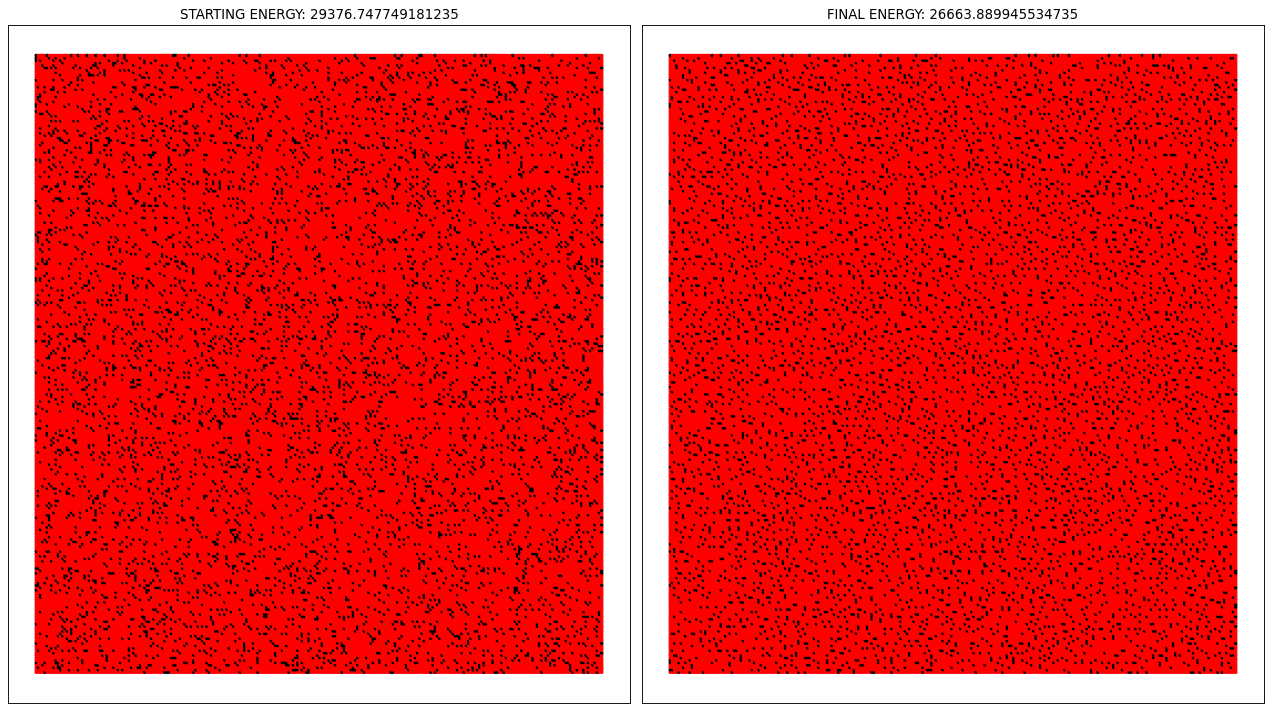

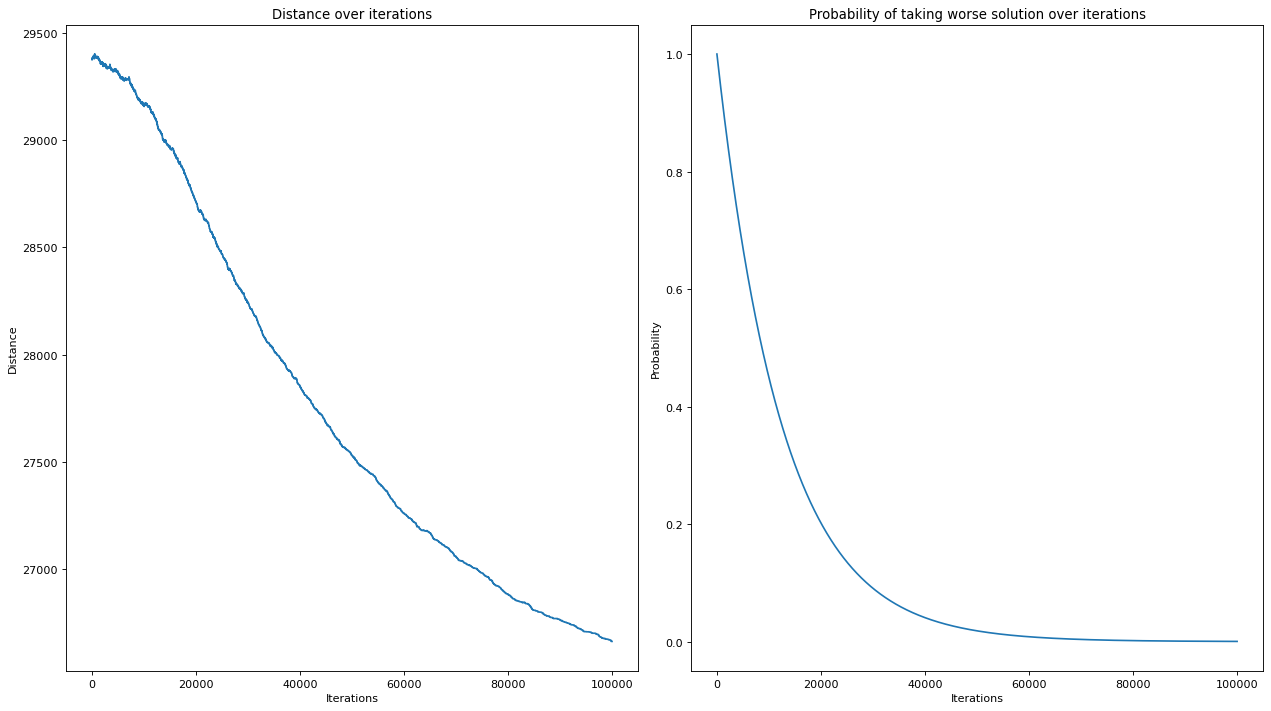

In [24]:
run_binary(1, {"n": 256}, {"max_iterations": 10**5, "neighbourhood": "four"})

### Four Neighbourhood Crossed


SOLUTION IN INTERATION NUMBER: 1


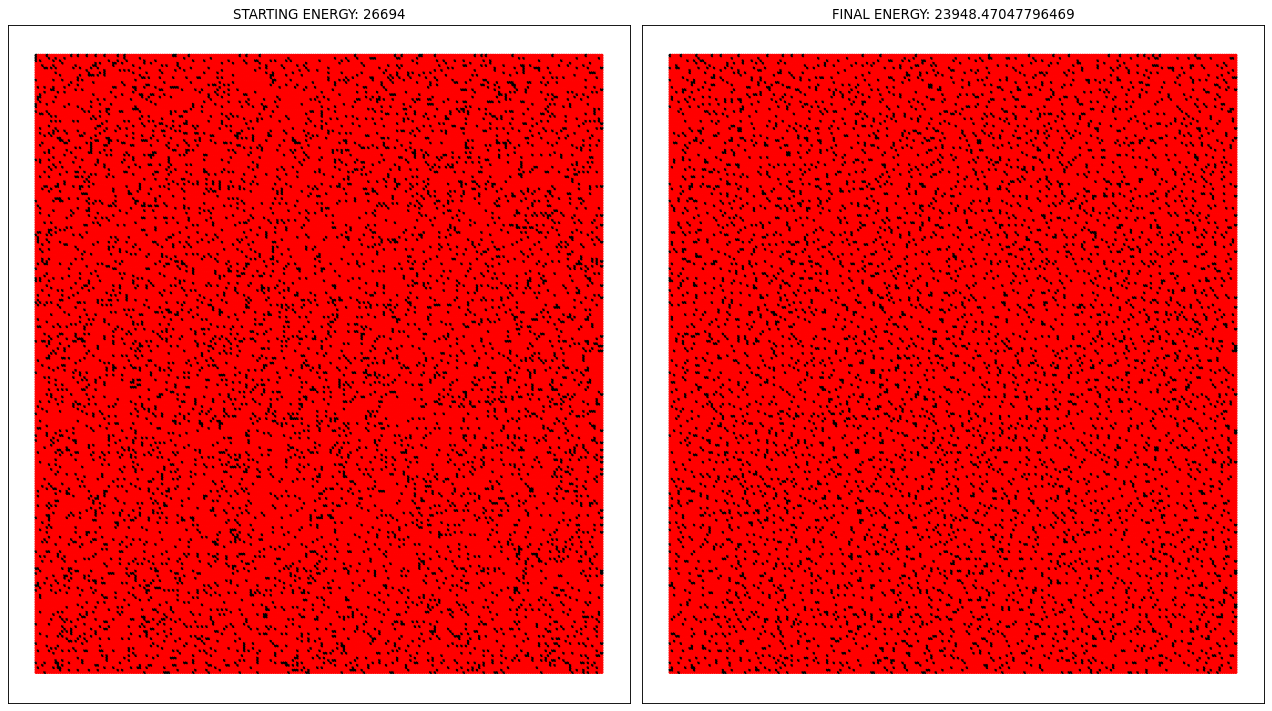

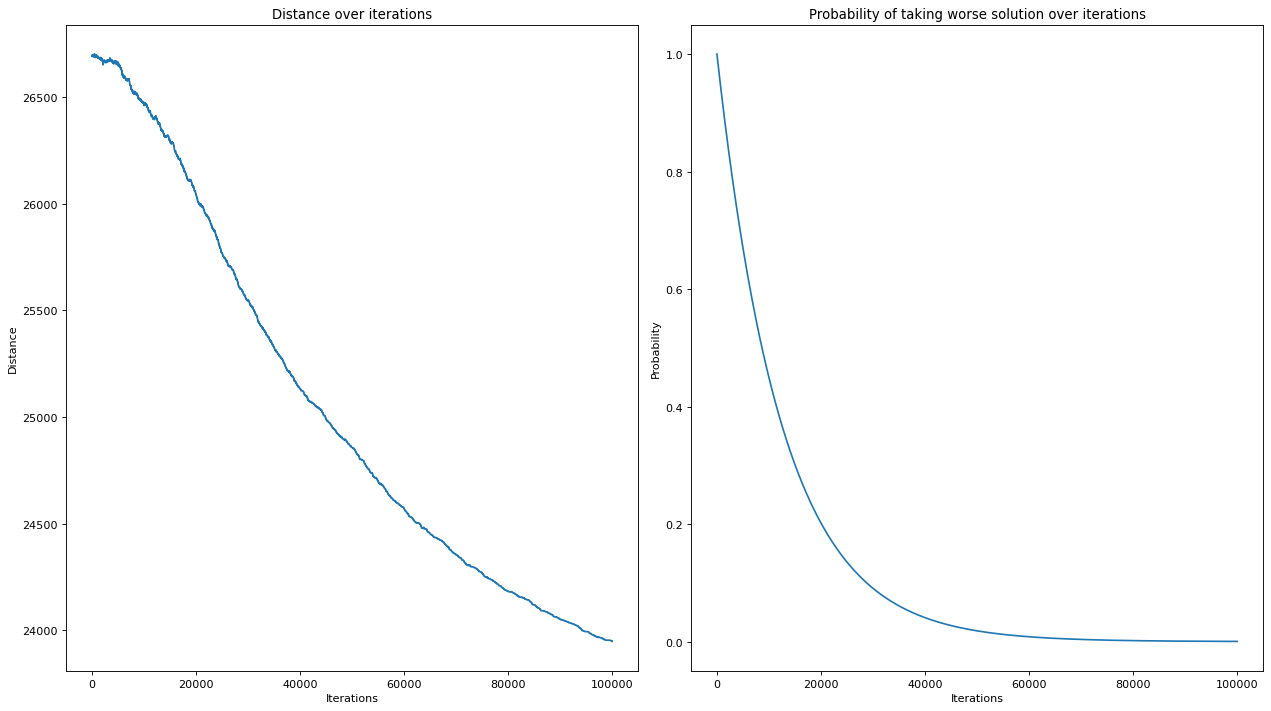

In [25]:
run_binary(1, {"n": 256}, {"max_iterations": 10**5, "neighbourhood": "four_crossed"})

### Around Neighbourhood

SOLUTION IN INTERATION NUMBER: 1


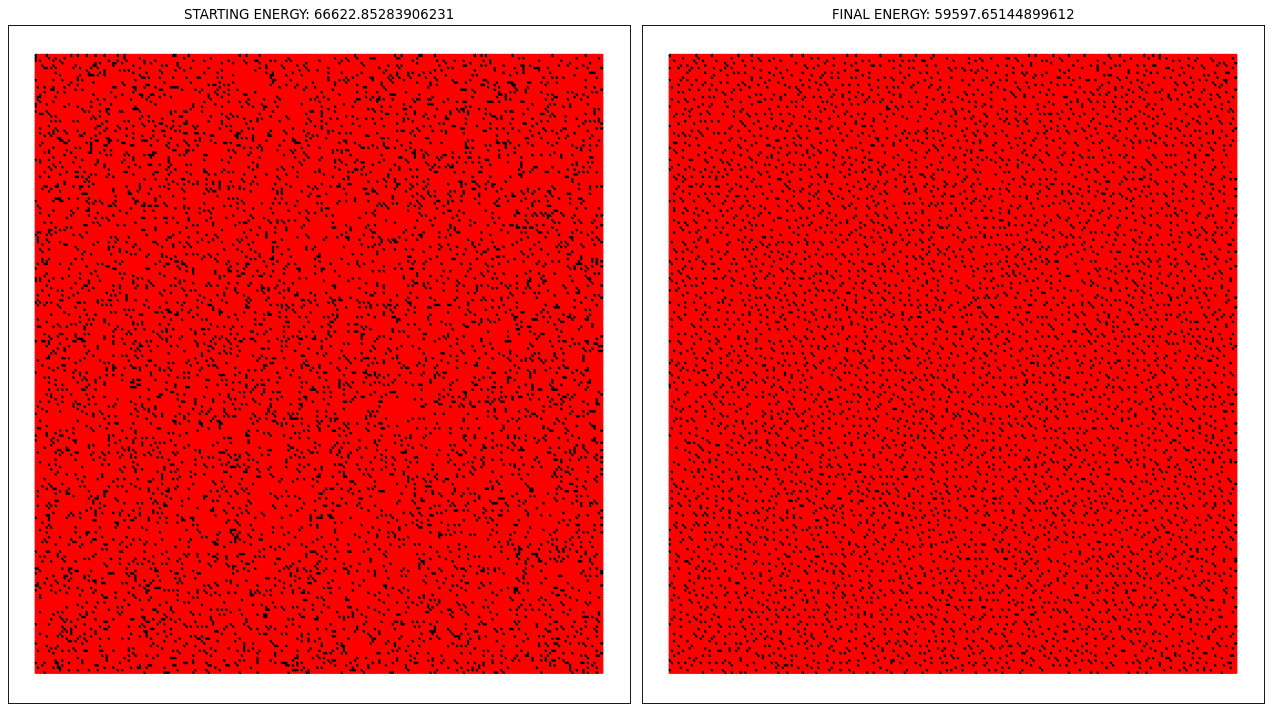

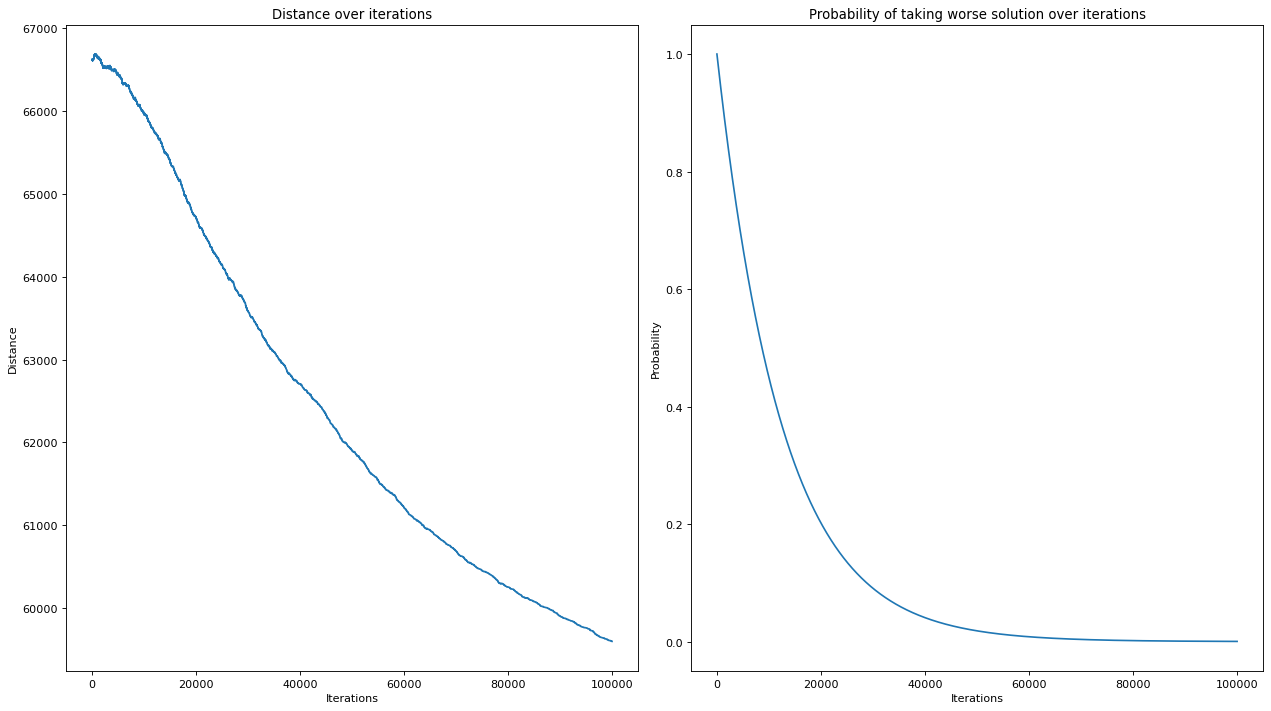

In [26]:
run_binary(1, {"n": 256}, {"max_iterations": 10**5, "neighbourhood": "around"})

### Row Neighbourhood

SOLUTION IN INTERATION NUMBER: 1


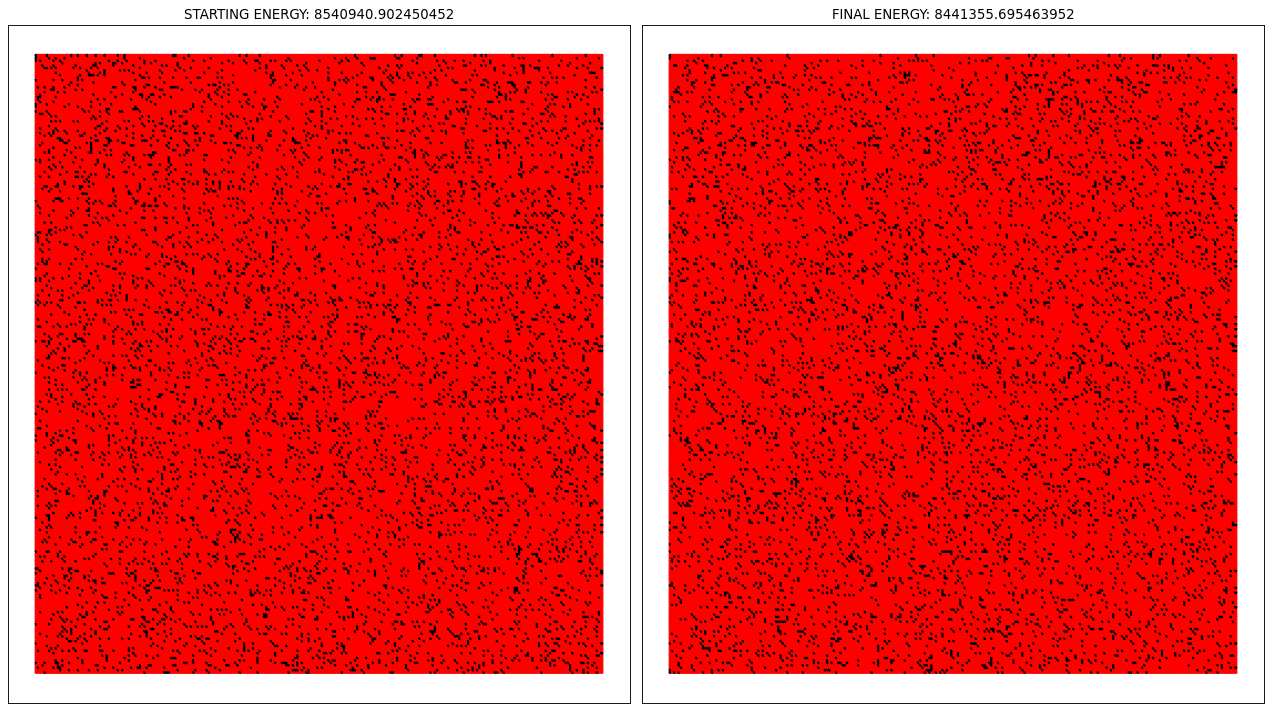

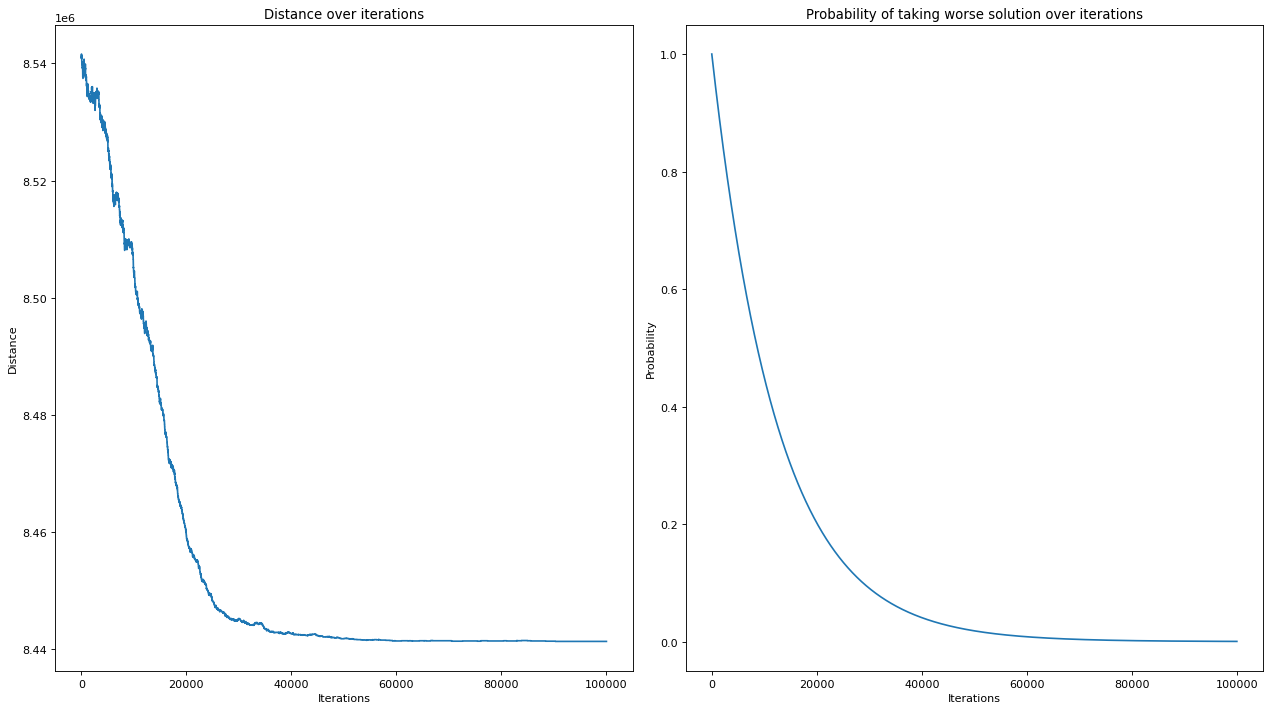

In [27]:
run_binary(1, {"n": 256}, {"max_iterations": 10**5, "neighbourhood": "row"})

### Col Neighbourhood

SOLUTION IN INTERATION NUMBER: 1


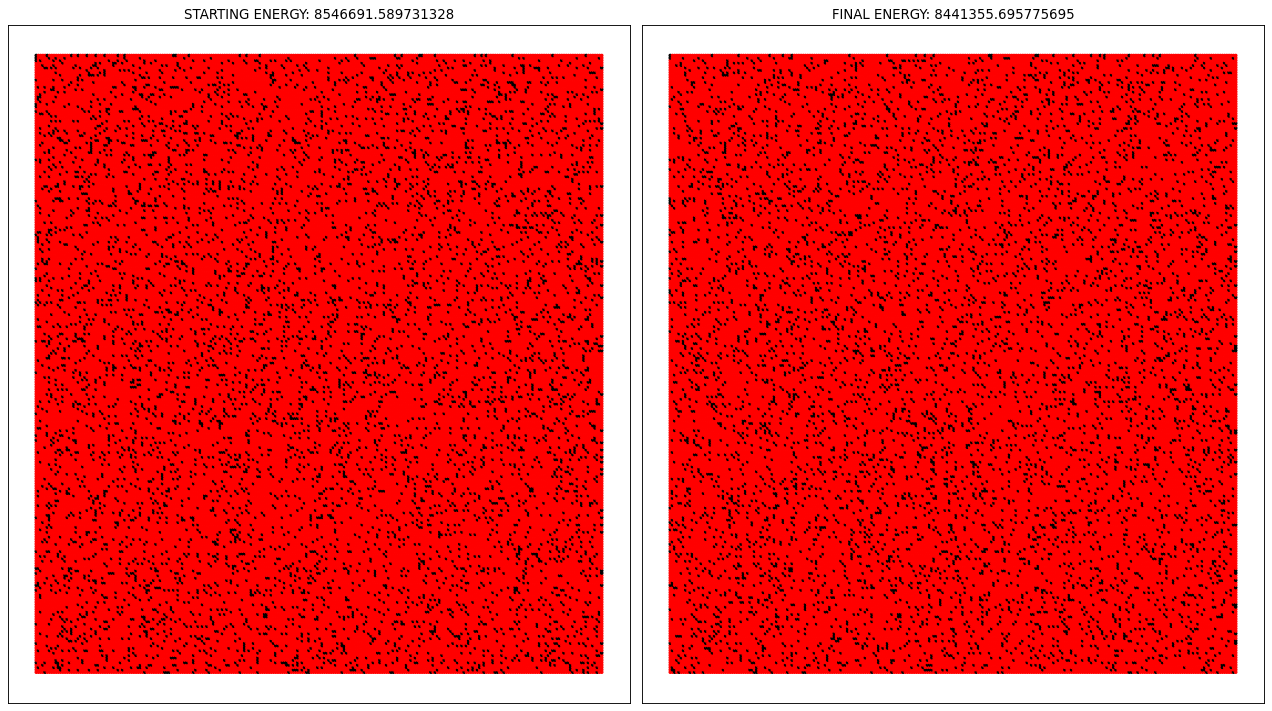

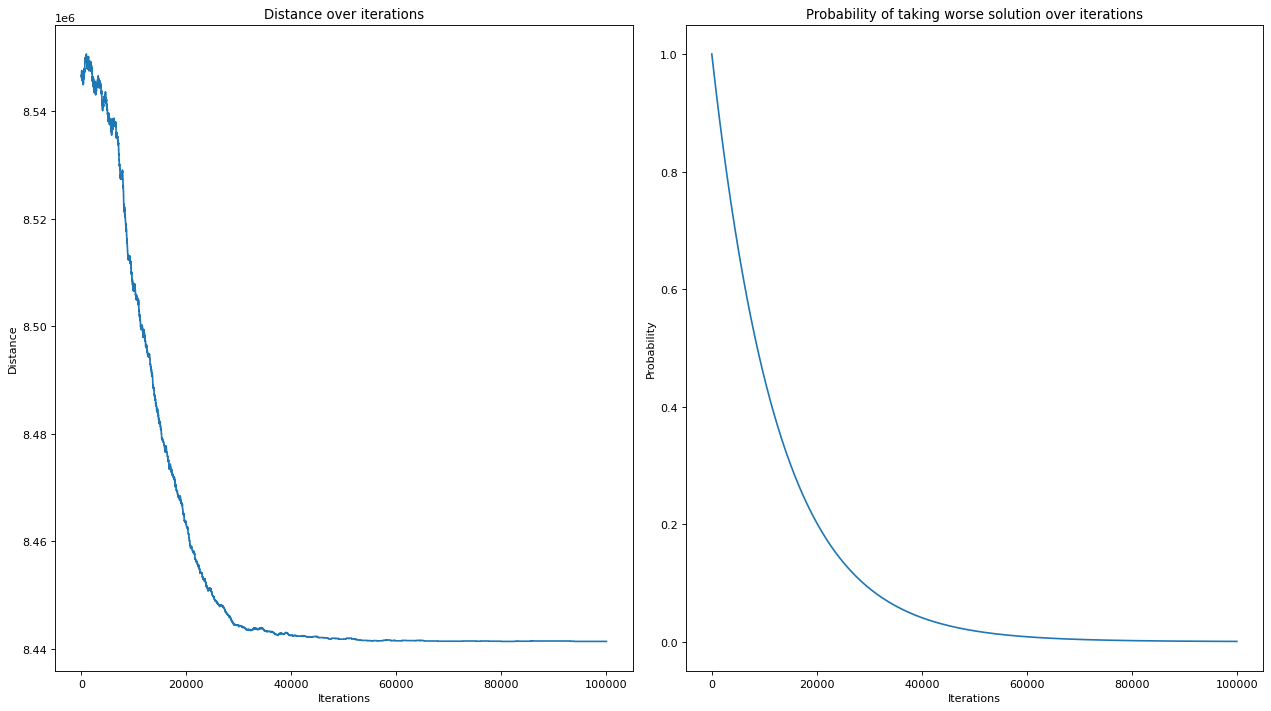

In [28]:
run_binary(1, {"n": 256}, {"max_iterations": 10**5, "neighbourhood": "col"})

### Row And Col Neighbourhood

SOLUTION IN INTERATION NUMBER: 1


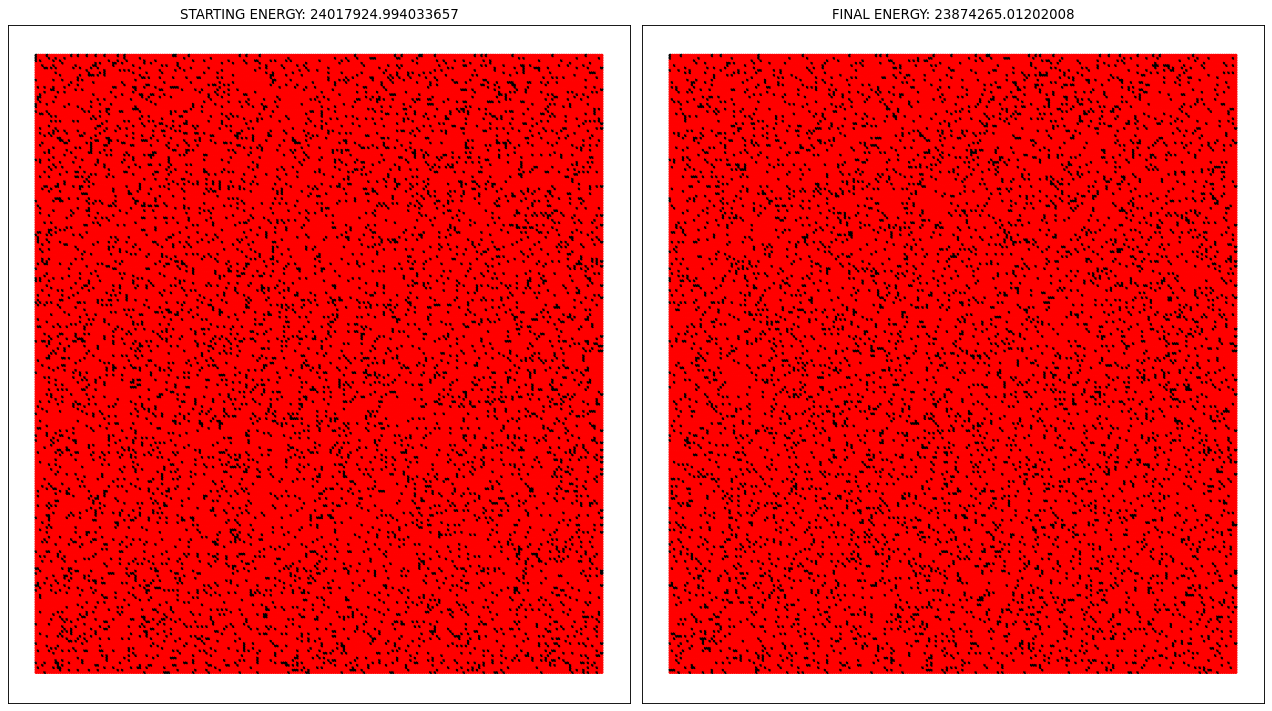

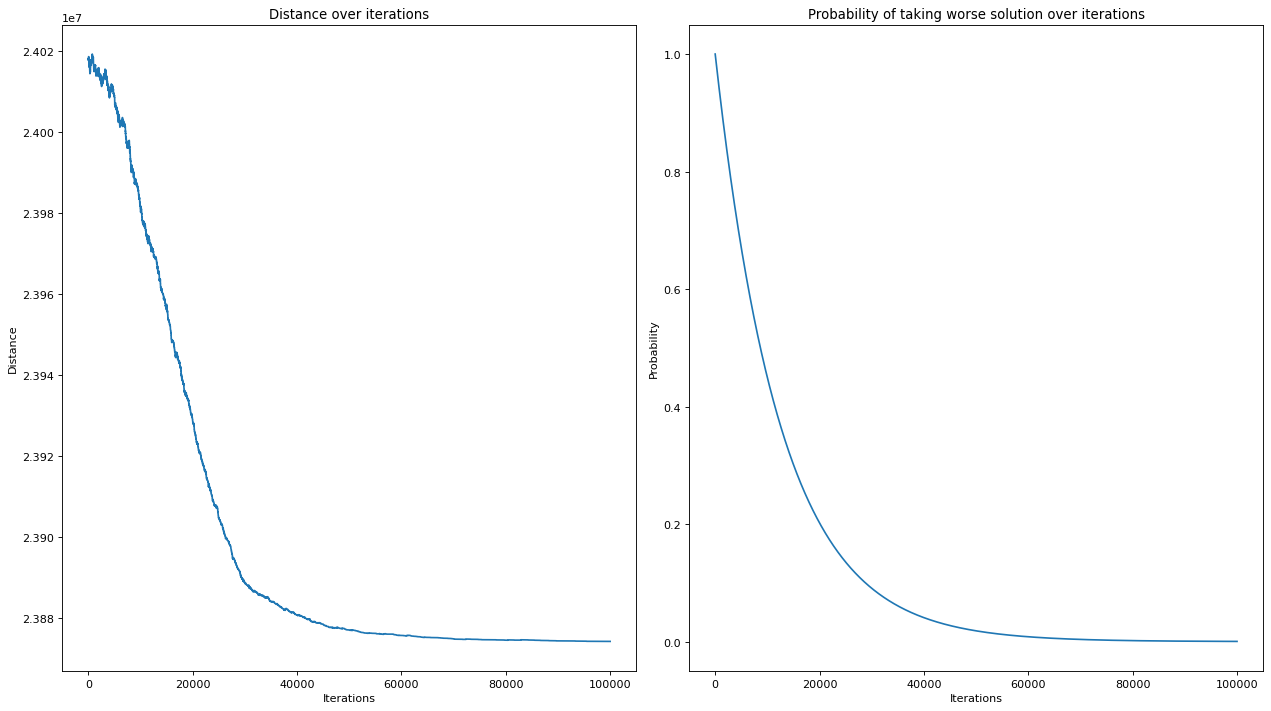

In [29]:
run_binary(1, {"n": 256}, {"max_iterations": 10**5, "neighbourhood": "row_and_col"})

Wnioski:
1. IKS DE TO WSZYSTKO WYGLĄDA TAK SAMO

## 3. Sudoku
benchmarkowe plaszne, gdzie jest dużo niewiadomych. Tam mamy przetestować wyzarzaniem. PObawaić się doborem parametrów - np. funkcje temperatruy.

### Wczytywanie macierzy z pliku

In [41]:
def get_matrix_from_file(file_name='sudoku2.txt'):
    with open(file_name, 'r') as f:
        lines = [line[:-1] for line in f]
        sudoku = np.asarray([[int(num) if num != 'x' else np.NAN for num in line.split(',')] for line in lines])

    return sudoku

### Struktury użyte w rozwiązaniu:
1) Temperature - klasa wykorzystywana do obsługi funkcji temperatury
2) Annealing - abstrakcyjna klasa po której dziedziczy Sudoku
3) Sudoku - klasa rozwiązująca sudoku

In [67]:
class SudokuCost:
    perfect_cost = 9*3*9 #each combination cost is 9

    def __init__(self, cost_func=lambda x: x**2):
        self._cost_func = cost_func

    def calculate_cost(self, arr: np.ndarray):
        counts = list(Counter(arr).values())
        return sum(map(self._cost_func, counts))

    def calculate_rectangle(self, matrix: np.ndarray):
        return self.calculate_cost(matrix.flatten())

class Sudoku(Annealing):
    def __init__(self, sudoku: np.ndarray, max_iterations: int, **kwargs):
        super().__init__(max_iterations)
        self._n = 9
        self._starting_sudoku = np.copy(sudoku)
        self._nans_indexes = self._generate_nan_indexes()
        self._sudoku = np.copy(sudoku)
        self._create_initial_solution()
        self._best_sudoku = np.copy(self._sudoku)
        self._cost = SudokuCost()
        self._starting_cost = self._calculate_beggining_cost()
        self._best_cost = self._starting_cost


    def set(self, sudoku: np.ndarray, max_iterations: int, **kwargs):
        self._reset(max_iterations)
        self._n = 9
        self._starting_sudoku = np.copy(sudoku)
        self._nans_indexes = self._generate_nan_indexes()
        self._sudoku = np.copy(sudoku)
        self._create_initial_solution()
        self._best_sudoku = np.copy(self._sudoku)
        self._cost = SudokuCost()
        self._starting_cost = self._calculate_beggining_cost()
        self._best_cost = self._starting_cost

    def _calculate_beggining_cost(self):
        cost = 0
        for i in range(self._n):
            cost += self._cost.calculate_cost(self._sudoku[i])
            cost += self._cost.calculate_cost(self._sudoku[:, i])
            cost += self._cost.calculate_rectangle(self._sudoku[3*(i//3) : 3 + 3*(i//3), 3*(i%3) : 3 + 3*(i%3)])

        return cost

    def _generate_nan_indexes(self):
        rows, cols = np.where(np.isnan(self._starting_sudoku))
        return [(rows[i], cols[i]) for i in range(len(rows))]

    def _create_initial_solution(self):
        for cord in self._nans_indexes:
            self._sudoku[cord] = np.random.randint(self._n+1)

    def solve(self):
        if self._is_used:
            raise Exception("Use .set() to use it again")

        curr_cost = self._best_cost
        self._results_over_time.append(curr_cost)
        for step in range(1, self._max_iterations+1):
            if np.isclose(self._best_cost, self._cost.perfect_cost):
                break

            indexes = self._nans_indexes[int(np.random.choice(np.arange(len(self._nans_indexes)), 1))]
            new_indexes_value = np.random.randint(9)

            if self._consecutive_swap or new_indexes_value == self._sudoku[indexes]:
                new_indexes_value = (self._sudoku[indexes] + 1) % 9

            cost_difference = self._calculate_difference(indexes, new_indexes_value)

            random = np.random.random()
            if cost_difference > 0 or random < self._temp.probability:
                self._sudoku[indexes] = new_indexes_value
                curr_cost -= cost_difference

            if curr_cost < self._best_cost:
                self._best_cost = curr_cost
                self._best_sudoku = np.copy(self._sudoku)

            self._temp.cool_down()
            self._results_over_time.append(curr_cost)

        self._is_used = True
        self._sudoku = self._best_sudoku

    def _calculate_difference(self, indexes: Tuple[int,int], new_value: int):
        r, c = indexes
        difference = 0
        row = np.copy(self._sudoku[r])
        col = np.copy(self._sudoku[:, c])
        rectangle = np.copy(self._sudoku[(r//3)*3: (r//3)*3 + 3, (c//3)*3: (c//3)*3 + 3])

        difference += self._cost.calculate_cost(row)
        difference += self._cost.calculate_cost(col)
        difference += self._cost.calculate_rectangle(rectangle)

        row[c] = new_value
        col[r] = new_value
        rectangle[r%3, c%3] = new_value

        return difference

    def draw_starting_and_ending_graph(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9), dpi=80)
        self.draw(ax = ax1, starting_binary=True)
        self.draw(ax = ax2)
        fig.tight_layout()
        plt.show()

    def draw(self, node_size=5, ax=None, starting_binary=False):
        if ax:
            p = ax
        else:
            plt.figure(figsize=(20, 15), dpi=80)
            p = plt

        image = self._starting_sudoku if starting_binary else self._best_sudoku
        title = "STARTING ENERGY" if starting_binary else "FINAL ENERGY"
        cost = self._starting_cost if starting_binary else self._best_cost

        G = nx.Graph()
        colors = []
        pos = dict()
        for i in range(self._n ** 2):
            G.add_node(i, value=self._best_sudoku[i // self._n, i % self._n])
            pos[i] = (i // self._n, i % self._n)
            colors.append("black" if image[i // self._n, i % self._n] == 1 else "red")

        nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=node_size, ax=ax)
        nx.draw_networkx_labels(G, pos)
        p.set_title(f"{title}: {cost}")

        if not ax: plt.show()

### Funckja wykonywania algorytmu

In [70]:
def run_sudoku(repeat, file_name, max_iterations, linear=False, seed=None, consecutive_swap=False, min_temp=-8):
    if seed: np.random.seed(seed)
    sudoku_matrix = get_matrix_from_file(file_name)
    sudoku = Sudoku(sudoku_matrix, max_iterations)

    if linear: sudoku.set_linear()
    else: sudoku.set_exponential(min_temp)
    if consecutive_swap: sudoku.set_consecutive_swap()

    best_cost, best_sudoku = float('inf'), None
    for i in range(1, repeat+1):
        sudoku.solve()
        sudoku.set(sudoku_matrix, max_iterations)

        if sudoku._best_cost < best_cost:
            best_cost = sudoku._best_cost
            best_sudoku = sudoku._best_sudoku
        if linear: sudoku.set_linear()
        else: sudoku.set_exponential(min_temp)
        if consecutive_swap: sudoku.set_consecutive_swap()

    print(f"BEST COST: {best_cost}")
    print(sudoku._starting_sudoku)
    print(best_sudoku)

### Sudoku from file: `sudoku1.txt`

In [77]:
run_sudoku(7,'sudoku1.txt', (10**5)*3)

BEST COST: 391
[[ 5.  3. nan nan  7. nan nan nan nan]
 [ 6. nan nan  1.  9.  5. nan nan nan]
 [nan  9.  8. nan nan nan nan  6. nan]
 [ 8. nan nan nan  6. nan nan nan  3.]
 [ 4. nan nan  8. nan  3. nan nan  1.]
 [ 7. nan nan nan  2. nan nan nan  6.]
 [nan  6. nan nan nan nan  2.  8. nan]
 [nan nan nan  4.  1.  9. nan nan  5.]
 [nan nan nan nan  8. nan nan  7.  9.]]
[[5. 3. 6. 3. 7. 1. 2. 4. 0.]
 [6. 1. 5. 1. 9. 5. 4. 4. 5.]
 [1. 9. 8. 1. 6. 7. 5. 6. 0.]
 [8. 9. 2. 4. 6. 0. 7. 8. 3.]
 [4. 0. 2. 8. 3. 3. 0. 9. 1.]
 [7. 0. 2. 2. 2. 4. 7. 8. 6.]
 [4. 6. 6. 5. 0. 9. 2. 8. 0.]
 [0. 3. 0. 4. 1. 9. 6. 3. 5.]
 [3. 2. 8. 9. 8. 0. 4. 7. 9.]]


In [74]:
run_sudoku(7,'sudoku2.txt', 10**5)

BEST COST: 361
[[ 1. nan nan  7. nan nan nan  2. nan]
 [ 8. nan nan nan nan nan nan  1.  6.]
 [ 9.  2. nan  5. nan  1.  7.  3. nan]
 [nan  3. nan nan  2. nan nan nan  4.]
 [nan nan nan nan nan  3. nan nan nan]
 [ 5.  9.  6. nan  1. nan  3. nan nan]
 [ 3. nan  1. nan  4.  6. nan nan nan]
 [nan  4. nan nan nan nan nan  9. nan]
 [ 6. nan nan  2. nan nan nan  4. nan]]
[[1. 5. 5. 7. 8. 8. 2. 2. 5.]
 [8. 3. 1. 6. 3. 9. 0. 1. 6.]
 [9. 2. 2. 5. 0. 1. 7. 3. 6.]
 [4. 3. 8. 5. 2. 6. 3. 6. 4.]
 [2. 5. 4. 7. 5. 3. 9. 0. 1.]
 [5. 9. 6. 6. 1. 0. 3. 7. 7.]
 [3. 9. 1. 8. 4. 6. 1. 6. 1.]
 [0. 4. 7. 9. 3. 3. 0. 9. 8.]
 [6. 2. 2. 2. 5. 7. 8. 4. 3.]]
